In [9]:
import uproot as up
import matplotlib.pyplot as plot
withQE = "/hpc/group/vossenlab/rck32/eic/work_eic/root_files/Clustering/May_06/benchmark_May_06_neutron_0_5GeV_to_5GeV500events_run_1_500_0.edm4hep.root"

lengths = []
with up.open(withQE) as file:
    tree = file['events']
    time = tree['HcalBarrelHits/HcalBarrelHits.time'].array(library = "np")
    for event_idx in range(len(time)):
        lengths.append(len(time[event_idx]))


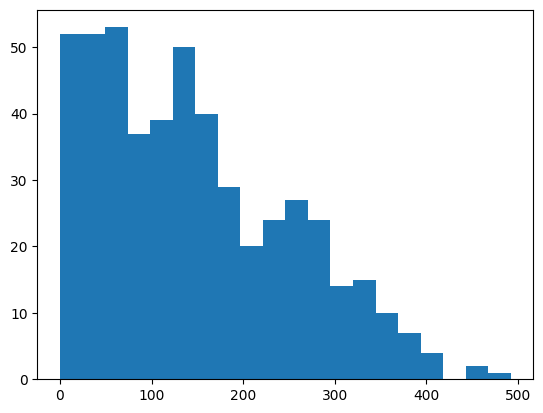

In [10]:
plot.hist(lengths,bins = 20);

In [2]:
import numpy as np

pre_shower_ratio = 0.45
value = 0.7
num_layers = 14
total = (55.5 + 20 + 0.3 * 2) * 14
units = "mm"
total_steel_scint = total - (0.3 * 2) * num_layers

steel_value = 55.5
scint_value = 20
total_steel_scint = (steel_value + scint_value) * num_layers
pre_shower_steel_scint_per_layer = (total_steel_scint * pre_shower_ratio) / 2
preshower_steel_value = pre_shower_steel_scint_per_layer * value
preshower_scint_value = pre_shower_steel_scint_per_layer - preshower_steel_value

In [10]:
value = 0.4
total_steel_scint = (steel_value + scint_value) * num_layers
post_shower_steel_scint_per_layer = (total_steel_scint * (1 - pre_shower_ratio)) / (num_layers - 2)
postshower_steel_value = post_shower_steel_scint_per_layer * value
postshower_scint_value = post_shower_steel_scint_per_layer - postshower_steel_value

In [11]:
print([preshower_steel_value,preshower_scint_value,postshower_steel_value,postshower_scint_value])

[166.4775, 71.34750000000003, 19.378333333333334, 29.0675]


In [1]:
import yaml
with open('out_irregular_pi.yaml', 'r') as file:
    loaded_data = yaml.safe_load(file)

In [18]:
Q2_edges = loaded_data['binscheme']['nested'][0]['Q2']['lims']
Q2_bins = loaded_data['binscheme']['nested'][0]['Q2']
Q2_bins['nested']

[{'x': {'nbins': 2,
   'lims': [0.07015535980463028, 0.14888569254055617, 0.3857077956199646]}},
 {'x': {'nbins': 2,
   'lims': [0.12384980916976929, 0.19688075773417948, 0.4393182694911957]}},
 {'x': {'nbins': 2,
   'lims': [0.15407304465770721, 0.24431943712234494, 0.5044084191322327]}},
 {'x': {'nbins': 2,
   'lims': [0.2004287838935852, 0.35714908230304726, 0.7672291398048401],
   'nested': [{'Q2': {'nbins': 1, 'lims': [0.0, 11.0]}},
    {'Q2': {'nbins': 3,
      'nested': [{'x': {'nbins': 2,
         'lims': [0.35714954137802124,
          0.41306415224075316,
          0.5593723654747009]}},
       {'x': {'nbins': 2,
         'lims': [0.35715314745903015,
          0.4316105833649636,
          0.6139029264450073]}},
       {'x': {'nbins': 2,
         'lims': [0.3571569621562958,
          0.4812448031127451,
          0.7672291398048401]}}],
      'lims': [3.1815011501312256,
       3.9980962961912154,
       5.005927392840386,
       10.740234375]}}]}}]

In [8]:
import numpy as np
# x,Q2
bins = np.array([
    [0.12,1.62],#0
    [0.21,1.77],#1
    [0.16,2.19],#2
    [0.26,2.22],#3
    [0.2,2.73],#4
    [0.32,2.82],#5
    [0.29,3.76],#6
    [0.39,3.8],#7
    [0.46,3.8],#8
    [0.398,5.1],#9
    [0.5,5.1], #10
    [0.42,5.9], #11
    [0.59,7.5] #12
])
#10 z bins
z_bins_even = np.arange(0.15,0.9,0.1)
pt_bins_even = np.arange(0.05,1.1,0.1)

In [33]:
df = {
    'Q2' : [],
    'x' : [],
    'z' : [],
    'pt' : []
}
for i in range(len(bins)):
    curr_x_q2 = bins[i]
    for j in range(len(z_bins_even)):
        curr_z = z_bins_even[j]
        for k in range(len(pt_bins_even)):
            curr_pt = pt_bins_even[k]
            df['Q2'].append(curr_x_q2[1])
            df['x'].append(curr_x_q2[0])
            df['pt'].append(curr_pt)
            df['z'].append(curr_z)

In [34]:
import pandas as pd

df = pd.DataFrame(df)
df

,Q2,x,z,pt
0,1.62,0.12,0.15,0.05
1,1.62,0.12,0.15,0.15
2,1.62,0.12,0.15,0.25
3,1.62,0.12,0.15,0.35
4,1.62,0.12,0.15,0.45
...,...,...,...,...
1139,7.50,0.59,0.85,0.65
1140,7.50,0.59,0.85,0.75
1141,7.50,0.59,0.85,0.85
1142,7.50,0.59,0.85,0.95


In [ ]:
# Need to filter out events that correspond to a bin - need to build bin edges

df = {
    'Q2' : [],
    'x' : [],
    'z' : [],
    'pt' : []
}
for i in range(len(bins)):
    curr_x_q2 = bins[i]
    for j in range(len(z_bins_even)):
        curr_z = z_bins_even[j]
        for k in range(len(pt_bins_even)):
            curr_pt = pt_bins_even[k]
            df['Q2'].append(curr_x_q2[1])
            df['x'].append(curr_x_q2[0])
            df['pt'].append(curr_pt)
            df['z'].append(curr_z)

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
data = pd.read_csv("./CLAS12_hadronic_and_partonic.csv")

# x and q2 2D binning
x_q2_bins = np.array([
    [0.12,1.62],#0
    [0.21,1.77],#1
    [0.16,2.19],#2
    [0.26,2.22],#3
    [0.2,2.73],#4
    [0.32,2.82],#5
    [0.29,3.76],#6
    [0.39,3.8],#7
    [0.46,3.8],#8
    [0.398,5.1],#9
    [0.5,5.1], #10
    [0.42,5.9], #11
    [0.59,7.5] #12
])
x_q2_edges = np.array([
    [[0,0.182],[0,4.5]], # 0
    [[0.182,1],[0,4.5]], #1
    [[0,0.23],[4.5,5.6]], #2
    [[0.23,1],[4.5,5.6]], #3
    [[0,0.29],[5.6,7.6]], #4
    [[0.29,1],[5.6,7.6]], #5
    [[0,0.4],[7.6,25]], #6
    [[0.4,0.476],[7.6,9]], #7
    [[0.476,1],[7.6,9]], #8
    [[0.4,0.48],[9,11.5]], #9
    [[0.48,1],[9,11.5]], #10
    [[0.4,0.52],[11.5,25]], #11
    [[0.52,1],[11.5,25]], #12
])

# Bin centers
z_bins_even = np.arange(0.15,0.9,0.1)
pt_bins_even = np.arange(0.05,1.1,0.1)
T_t_bins_even = np.arange(0.175,3.6,0.35)

z_bin_edges = np.arange(0.15,0.9,0.1)
z_bin_edges -= 0.05
z_bin_edges = np.append(z_bin_edges, z_bin_edges[-1] + 0.1)

pt_bin_edges = np.arange(0.05,1.1,0.1)
pt_bin_edges -= 0.05
pt_bin_edges = np.append(pt_bin_edges, pt_bin_edges[-1] + 0.1)

T_t_bin_edges = np.arange(0.175,3.6,0.35)
T_t_bin_edges -= 0.175
T_t_bin_edges = np.append(T_t_bin_edges, T_t_bin_edges[-1] + 0.15)


#loop over 2d bins
df = {
    'x' : [],
    'Q' : [],
    'z' : [],
    'T_t' : [],
    'R2' : []
}
size = 100

for i in range(len(x_q2_edges)):
    curr_x_q2_bin_centers = x_q2_bins[i]
    curr_x_center = curr_x_q2_bin_centers[0]
    curr_q2_center = curr_x_q2_bin_centers[1]
    
    curr_x_q2_bins = x_q2_edges[i]
    curr_x_edges = curr_x_q2_bins[0]
    curr_q2_edges = curr_x_q2_bins[1]
    curr_q_edges = np.sqrt(curr_q2_edges)
    for j in range(len(z_bins_even)):
        curr_z_edges = np.array([z_bin_edges[j],z_bin_edges[j+1]])
        curr_z_center = z_bins_even[j]
        for k in range(len(T_t_bins_even)):
            curr_T_t_center = T_t_bins_even[k]
            curr_T_t_edges = np.array([T_t_bin_edges[k],T_t_bin_edges[k+1]])
            filtered_data = data[((data['Q'] > curr_q_edges[0]) & (data['Q'] < curr_q_edges[1])) & 
                                 ((data['x'] > curr_x_edges[0]) & (data['x'] < curr_x_edges[1])) &
                                 ((data['z'] > curr_z_edges[0]) & (data['z'] < curr_z_edges[1])) &
                                 ((data['T_t'] > curr_T_t_edges[0]) & (data['T_t'] < curr_T_t_edges[1]))
                                ]
            if(len(filtered_data) < size * 2):
                continue
            samples = filtered_data.sample(n = size)
            
            # Do some calculations:
            samples['R2'] = (samples['M_ki'] ** 2 ) / (samples['Q'] ** 2) #assuming kf = ki + q
            df['R2'].append(samples.loc[:,'R2'].mean())
            df['x'].append(curr_x_center)
            df['Q'].append(np.sqrt(curr_q2_center))
            df['z'].append(curr_z_center)
            df['T_t'].append(curr_T_t_center)
R2_df = pd.DataFrame(df)
# R2_df.to_csv("/file/path/")

[Text(0, 0.5, 'Counts')]

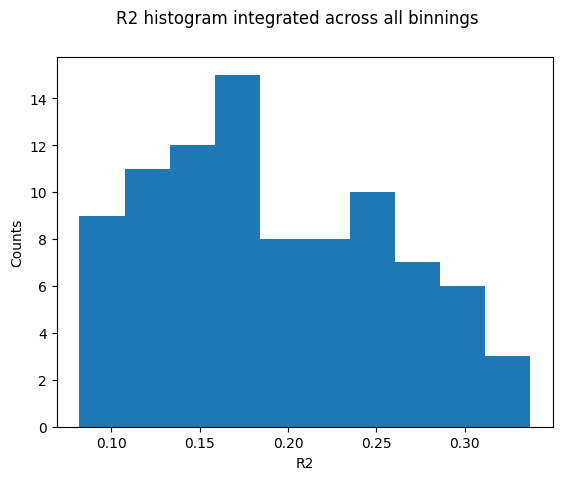

In [99]:
fig, axs = plot.subplots(1,1)
fig.suptitle("R2 histogram integrated across all binnings")
axs.hist(R2_df['R2'])
axs.set(xlabel = "R2")
axs.set(ylabel = "Counts")

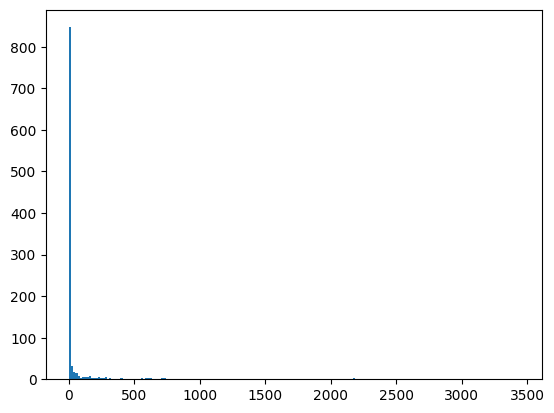

In [85]:
import matplotlib.pyplot as plot
plot.hist(lengths,bins = 200);

(0.0, 12.0)

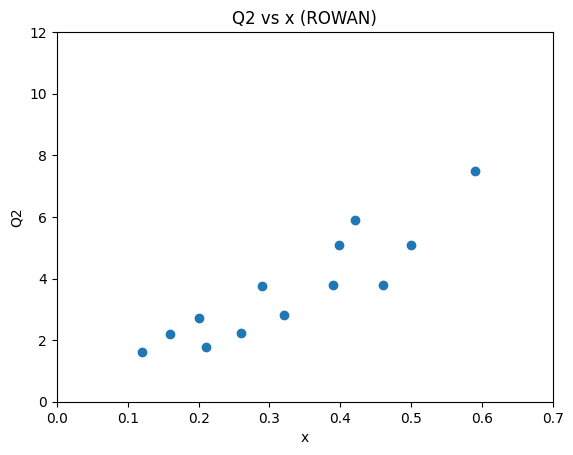

In [36]:
import matplotlib.pyplot as plot
plot.scatter(bins[:,0],bins[:,1])
plot.xlabel("x")
plot.ylabel("Q2")
plot.title("Q2 vs x (ROWAN)")
plot.xlim(0,0.7)
plot.ylim(0,12)

(0.0, 4.0)

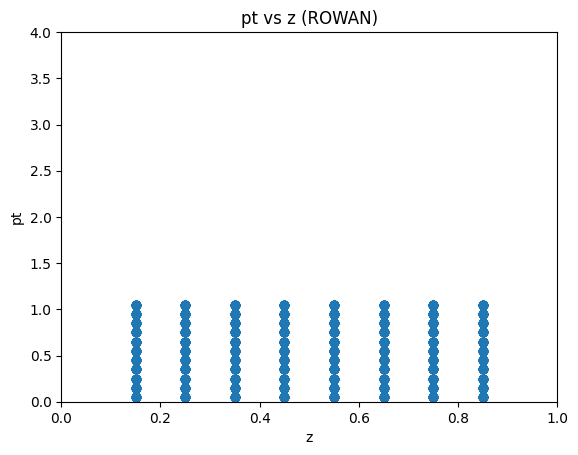

In [38]:
plot.scatter(df['z'],df['pt'])
plot.title("pt vs z (ROWAN)")
plot.xlabel('z')
plot.ylabel('pt')
plot.xlim(0,1)
plot.ylim(0,4)

In [39]:
df.to_csv("binned_hadronic.csv")

# MU/PI consistency:


In [ ]:
# status_quo = np.array([
#     [8.496224899598394664e-01,8.359516129032258380e-01],
#     [8.793086628511965763e-01,8.034929845266194359e-01],
#     [8.777085020242915148e-01,7.893964725937581139e-01],
#     [8.864356144704191864e-01,7.911325301204819027e-01],
#     [8.819454524927017314e-01,7.920000000000000373e-01]
#                       ])
# more_events = np.array([
#     [8.650658973923864847e-01,8.120469557903070568e-01],
#     [8.849454545454544796e-01,8.125897959183673303e-01],
#     [8.636866012436844597e-01,8.245598845598844928e-01],
#     [8.751923076923076028e-01,8.018918078911208003e-01],
#     [8.773302465394778871e-01,8.022034864776800278e-01]
#                       ])

In [ ]:
# print(f"low energy: \nmean: {np.mean(status_quo[:,0])}; sigma: {np.std(status_quo[:,0])}; %: {100 * np.std(status_quo[:,0]) / np.mean(status_quo[:,0])}")
# print(f"high energy: \nmean: {np.mean(status_quo[:,1])}; sigma: {np.std(status_quo[:,1])}; %: {100 * np.std(status_quo[:,1]) / np.mean(status_quo[:,1])}")

In [ ]:
# print(f"low energy: \nmean: {np.mean(more_events[:,0])}; sigma: {np.std(more_events[:,0])}; %: {100 * np.std(more_events[:,0]) / np.mean(more_events[:,0])}")
# print(f"high energy: \nmean: {np.mean(more_events[:,1])}; sigma: {np.std(more_events[:,1])}; %: {100 * np.std(more_events[:,1]) / np.mean(more_events[:,1])}")

In [10]:
import numpy as np
import pandas as pd
import uproot as up
import matplotlib.pyplot as plot

In [9]:
results_run_2 = [np.array([0.47680754, 0.69616156]),
 np.array([0.48205331, 0.69371943]),
 np.array([0.50743399, 0.7062432 ]),
 np.array([0.49544301, 0.71127527]),
 np.array([0.46124511, 0.70066392]),
 np.array([0.48409839, 0.70619878]),
 np.array([0.50697619, 0.69471931]),
 np.array([0.47609963, 0.71617119]),
 np.array([0.46109237, 0.71169262]),
 np.array([0.49443444, 0.6956393 ])]

In [6]:
i = 0
inc = 3
low_avgs = []
high_avgs = []
while i < len(results_2):
    start = i
    end = i + inc
    curr_results = results_2[start:end]
    low_avg = np.mean([x[0] for x in curr_results])
    high_avg = np.mean([x[1] for x in curr_results])
    low_avgs.append(low_avg)
    high_avgs.append(high_avg)
    i += inc

mean, sigma: 0.48621273833333334,0.005761597738376841


(0.0, 1.0)

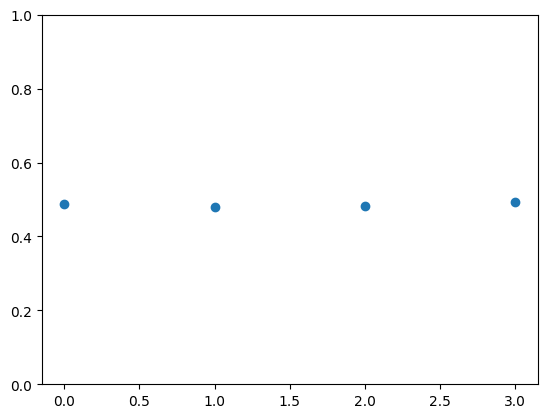

In [8]:
plot.scatter(range(len(low_avgs)),low_avgs)
sigma = np.std(np.array(low_avgs))
print(f"mean, sigma: {np.mean(low_avgs)},{sigma}")
plot.ylim(0,1)

In [ ]:
plot.scatter(range(len(high_avgs)),high_avgs)
sigma = np.std(np.array(high_avgs))
print(f"mean, sigma: {np.mean(high_avgs)},{sigma}")
plot.ylim(0,1)

Low E RMSE (mean,sigma): (0.4846,0.0157)
High E RMSE (mean,sigma): (0.7032,0.0077)


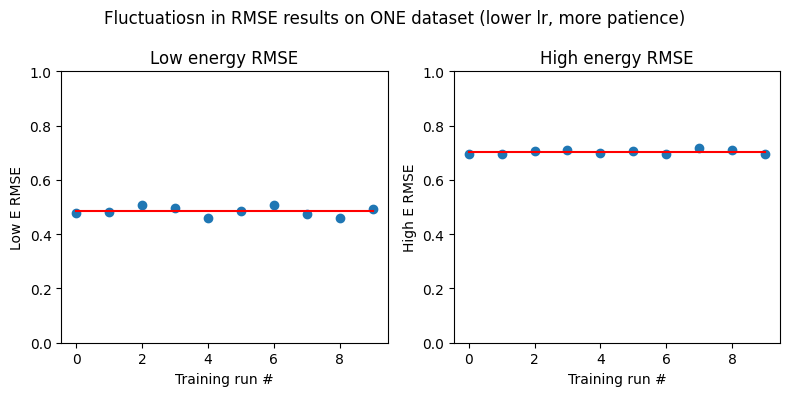

In [10]:
fig, axs = plot.subplots(1,2,figsize = (8,4))
fig.suptitle("Fluctuatiosn in RMSE results on ONE dataset (lower lr, more patience)")
axs[0].set_title("Low energy RMSE")
axs[0].scatter(range(len(results_run_2)),[result[0] for result in results_run_2])
axs[0].set_ylim(0,1)
axs[0].set_ylabel("Low E RMSE")
axs[0].set_xlabel("Training run #")
axs[0].plot([0,9],[np.mean([result[0] for result in results_run_2]),np.mean([result[0] for result in results_run_2])],color = 'r')
axs[1].set_title("High energy RMSE")
axs[1].scatter(range(len(results_run_2)),[result[1] for result in results_run_2])
axs[1].set_ylim(0,1)
axs[1].set_ylabel("High E RMSE")
axs[1].set_xlabel("Training run #")
axs[1].plot([0,9],[np.mean([result[1] for result in results_run_2]),np.mean([result[1] for result in results_run_2])],color = 'r')
fig.tight_layout()

low_RMSEs_2 = np.array([result[0] for result in results_run_2])
high_RMSEs_2 = np.array([result[1] for result in results_run_2])

low_sigma_2 = np.std(low_RMSEs_2)
low_mean_2 = np.mean(low_RMSEs_2)
high_sigma_2 = np.std(high_RMSEs_2)
high_mean_2 = np.mean(high_RMSEs_2)
print(f"Low E RMSE (mean,sigma): ({low_mean_2.item():0.4f},{low_sigma_2.item():0.4f})")
print(f"High E RMSE (mean,sigma): ({high_mean_2.item():0.4f},{high_sigma_2.item():0.4f})")

In [3]:
import numpy as np
import torch

In [54]:
binned_rmses = np.array([[0.47418482, 0.70235904],
       [0.47578152, 0.71793617],
       [0.50163552, 0.69430834],
       [0.49998098, 0.70125567],
       [0.47889369, 0.71004473],
       [0.50338991, 0.71412654],
       [0.50647768, 0.70337798],
       [0.49634454, 0.70143317],
       [0.48677855, 0.68931638],
       [0.49357663, 0.68882538],
       [0.48065522, 0.70920395],
       [0.50978023, 0.6887823 ],
       [0.51702292, 0.68412649],
       [0.49716578, 0.69368952],
       [0.48174223, 0.69895824],
       [0.48090013, 0.70039129],
       [0.48750497, 0.7089387 ],
       [0.50062107, 0.68844014],
       [0.49530892, 0.69271321],
       [0.49102097, 0.70028911],
       [0.48581742, 0.69411414],
       [0.48104962, 0.69782669],
       [0.49679598, 0.69131035],
       [0.47369103, 0.70834939],
       [0.47579754, 0.70729752],
       [0.49226727, 0.7077156 ],
       [0.48883536, 0.68845038],
       [0.48972004, 0.69719531],
       [0.47884211, 0.70931386],
       [0.46616287, 0.71333792],
       [0.51230542, 0.70442206],
       [0.49438638, 0.69857141],
       [0.49349322, 0.69932938],
       [0.51226483, 0.70852124],
       [0.47989917, 0.70625649],
       [0.51513681, 0.69308026],
       [0.5072736 , 0.69046986],
       [0.46337738, 0.70831659],
       [0.51551499, 0.70734336],
       [0.47277222, 0.69387793]])



In [55]:
model_val_losses = [[0.84046870470047,
  0.6048131585121155,
  0.5287848114967346,
  0.5028037428855896,
  0.5171841979026794,
  0.48172682523727417,
  0.4859100878238678,
  0.46071672439575195,
  0.472040593624115,
  0.45910897850990295,
  0.4522053301334381,
  0.4511794447898865,
  0.4516535699367523,
  0.4558492600917816,
  0.4357830584049225,
  0.44166576862335205,
  0.42975980043411255,
  0.4416090250015259,
  0.4294404983520508,
  0.4302977919578552,
  0.42005541920661926,
  0.41866403818130493,
  0.41511836647987366,
  0.44699516892433167,
  0.40989866852760315,
  0.4709186851978302,
  0.42469874024391174,
  0.41019901633262634,
  0.40664035081863403,
  0.40996721386909485,
  0.41234052181243896,
  0.4394373893737793,
  0.4129870533943176,
  0.4130994975566864,
  0.40544912219047546,
  0.39440298080444336,
  0.40520191192626953,
  0.39942336082458496,
  0.40119585394859314,
  0.4028873145580292,
  0.4193320870399475,
  0.40726563334465027,
  0.40023159980773926,
  0.3959963023662567],
 [0.7966215014457703,
  0.61082923412323,
  0.5405819416046143,
  0.4916752278804779,
  0.4824954867362976,
  0.47307997941970825,
  0.4488430619239807,
  0.44349896907806396,
  0.44501736760139465,
  0.4400992691516876,
  0.4375014901161194,
  0.4271853566169739,
  0.440919429063797,
  0.4240351617336273,
  0.4282405972480774,
  0.4191815257072449,
  0.4325098693370819,
  0.4222070276737213,
  0.42478492856025696,
  0.42288723587989807,
  0.4255329370498657,
  0.41848134994506836,
  0.4121125638484955,
  0.41574108600616455,
  0.42126670479774475,
  0.4125775098800659,
  0.40829986333847046,
  0.4108501374721527,
  0.4369537830352783,
  0.41005074977874756,
  0.4139374792575836,
  0.4095161259174347,
  0.4061758816242218,
  0.4213787019252777,
  0.4144807457923889,
  0.4092260003089905,
  0.4079815447330475,
  0.4076572060585022,
  0.4123048186302185,
  0.4113020896911621,
  0.4108498692512512],
 [0.783916175365448,
  0.6679088473320007,
  0.6368071436882019,
  0.5611253380775452,
  0.5143424272537231,
  0.5389801263809204,
  0.47982439398765564,
  0.5634714961051941,
  0.4653531312942505,
  0.45669251680374146,
  0.4589255452156067,
  0.4532744288444519,
  0.4398978650569916,
  0.4551427960395813,
  0.47483083605766296,
  0.4622980058193207,
  0.4344525635242462,
  0.4345209300518036,
  0.4257996082305908,
  0.4294072687625885,
  0.45872655510902405,
  0.5087656378746033,
  0.484658807516098,
  0.43412163853645325,
  0.46185898780822754,
  0.41918984055519104,
  0.4125877916812897,
  0.41115716099739075,
  0.41799017786979675,
  0.46037402749061584,
  0.4253847897052765,
  0.4152388870716095,
  0.42461976408958435,
  0.4062449634075165,
  0.43624037504196167,
  0.4157692790031433,
  0.4206526279449463,
  0.4366706907749176,
  0.3992074728012085,
  0.4355241358280182,
  0.4223290681838989,
  0.45178931951522827,
  0.40988361835479736,
  0.41656744480133057,
  0.40621066093444824,
  0.4012784957885742,
  0.414514422416687],
 [0.6935251951217651,
  0.5451628565788269,
  0.5140708684921265,
  0.48230138421058655,
  0.47638460993766785,
  0.46100425720214844,
  0.4609774351119995,
  0.44705021381378174,
  0.4504622220993042,
  0.4369368851184845,
  0.47141334414482117,
  0.4852237105369568,
  0.4651935398578644,
  0.43818411231040955,
  0.4190307557582855,
  0.4373764991760254,
  0.4218572974205017,
  0.43821075558662415,
  0.43544483184814453,
  0.5342881083488464,
  0.4207141101360321,
  0.41767674684524536,
  0.45012831687927246,
  0.40329253673553467,
  0.4163335859775543,
  0.4045032262802124,
  0.42272353172302246,
  0.44600218534469604,
  0.4155246615409851,
  0.40998879075050354,
  0.41083112359046936,
  0.4177028238773346],
 [0.7652350068092346,
  0.6043699383735657,
  0.5563509464263916,
  0.5219586491584778,
  0.49199455976486206,
  0.4729052186012268,
  0.46347418427467346,
  0.49576959013938904,
  0.49642208218574524,
  0.44803550839424133,
  0.4540726840496063,
  0.447910875082016,
  0.4380166530609131,
  0.43500685691833496,
  0.470866858959198,
  0.4669303596019745,
  0.45206430554389954,
  0.4271964728832245,
  0.4302721917629242,
  0.4293142259120941,
  0.42932501435279846,
  0.45858511328697205,
  0.4355742037296295,
  0.42440488934516907,
  0.4382937252521515,
  0.4131600260734558,
  0.4208497405052185,
  0.4539046287536621,
  0.45523545145988464,
  0.4178743362426758,
  0.41568616032600403,
  0.4117386043071747,
  0.4286198019981384,
  0.4300483465194702,
  0.4239867031574249,
  0.4151393175125122,
  0.42362159490585327,
  0.43393367528915405,
  0.42783206701278687,
  0.40934234857559204,
  0.3998294770717621,
  0.44215404987335205,
  0.4392383396625519,
  0.40421080589294434,
  0.4067893326282501,
  0.41797760128974915,
  0.4037327170372009,
  0.41190415620803833,
  0.4031347334384918],
 [0.7560726404190063,
  0.5792679190635681,
  0.5477275252342224,
  0.4970129132270813,
  0.4790079593658447,
  0.470365434885025,
  0.463785320520401,
  0.45032501220703125,
  0.4669627249240875,
  0.44135940074920654,
  0.4383367896080017,
  0.4331262707710266,
  0.4286622703075409,
  0.43743017315864563,
  0.4350300431251526,
  0.4292495846748352,
  0.41737279295921326,
  0.4101353883743286,
  0.421355664730072,
  0.4112167954444885,
  0.4305141866207123,
  0.41200029850006104,
  0.41796308755874634,
  0.41785287857055664,
  0.410396546125412,
  0.42467084527015686],
 [0.7475317716598511,
  0.6047364473342896,
  0.5830790996551514,
  0.5246501564979553,
  0.4948072135448456,
  0.49420350790023804,
  0.4884783625602722,
  0.4750487208366394,
  0.46677136421203613,
  0.449623167514801,
  0.48184099793434143,
  0.4438488781452179,
  0.49614253640174866,
  0.45031654834747314,
  0.44803586602211,
  0.4382952153682709,
  0.44461938738822937,
  0.42820459604263306,
  0.5088359713554382,
  0.42862504720687866,
  0.46583810448646545,
  0.44927331805229187,
  0.4302229881286621,
  0.4641938805580139,
  0.4529092311859131,
  0.41737857460975647,
  0.464091032743454,
  0.42403310537338257,
  0.4282171130180359,
  0.41459107398986816,
  0.4331280291080475,
  0.4318959712982178,
  0.4073963761329651,
  0.40755367279052734,
  0.44000282883644104,
  0.40385445952415466,
  0.4092123210430145,
  0.40330028533935547,
  0.473709374666214,
  0.4073840379714966,
  0.42240431904792786,
  0.4036029875278473,
  0.4091387391090393,
  0.4301690459251404,
  0.4229075014591217,
  0.41151440143585205],
 [0.7095036506652832,
  0.5884243249893188,
  0.5566801428794861,
  0.48058009147644043,
  0.4629005193710327,
  0.47707441449165344,
  0.4472205340862274,
  0.45594462752342224,
  0.450979620218277,
  0.43959811329841614,
  0.4342007339000702,
  0.4408288300037384,
  0.4296741187572479,
  0.45290863513946533,
  0.42711973190307617,
  0.4263862371444702,
  0.42518576979637146,
  0.413734495639801,
  0.4207978844642639,
  0.4370557963848114,
  0.46289077401161194,
  0.41928789019584656,
  0.43594497442245483,
  0.4391445219516754,
  0.40891245007514954,
  0.4113766849040985,
  0.43857869505882263,
  0.4222964644432068,
  0.4067820906639099,
  0.40532928705215454,
  0.40524327754974365,
  0.40288129448890686,
  0.45099151134490967,
  0.3986043334007263,
  0.40326204895973206,
  0.40177658200263977,
  0.4084320366382599,
  0.40137940645217896,
  0.4059745669364929,
  0.4015507996082306,
  0.41188690066337585,
  0.4541100263595581],
 [0.802965521812439,
  0.6907197833061218,
  0.5579318404197693,
  0.5319287180900574,
  0.5200856924057007,
  0.5019586682319641,
  0.4958752989768982,
  0.48588672280311584,
  0.46840015053749084,
  0.4761868119239807,
  0.4685775637626648,
  0.46238386631011963,
  0.48006218671798706,
  0.4531134366989136,
  0.43631240725517273,
  0.49561914801597595,
  0.42607706785202026,
  0.45289117097854614,
  0.43490371108055115,
  0.453874796628952,
  0.41856810450553894,
  0.4324148893356323,
  0.41907620429992676,
  0.41753828525543213,
  0.448678582906723,
  0.4149588644504547,
  0.42608213424682617,
  0.40947696566581726,
  0.4146289825439453,
  0.415517121553421,
  0.40753477811813354,
  0.44325461983680725,
  0.4386431574821472,
  0.4324533939361572,
  0.40971747040748596,
  0.4110247492790222,
  0.4319837689399719,
  0.43180620670318604,
  0.4000808596611023,
  0.41324684023857117,
  0.4171885550022125,
  0.42452457547187805,
  0.41212791204452515,
  0.3961254954338074,
  0.4080043435096741,
  0.40729930996894836,
  0.40233659744262695,
  0.401581734418869,
  0.4225229024887085,
  0.4225780963897705,
  0.39435380697250366,
  0.4070066809654236,
  0.39802661538124084,
  0.39749789237976074,
  0.39880502223968506,
  0.3981426954269409,
  0.3994925022125244,
  0.4150031805038452,
  0.4153125584125519],
 [0.6950963735580444,
  0.5736109018325806,
  0.5443792343139648,
  0.4888327717781067,
  0.5010312795639038,
  0.4899570345878601,
  0.4526262581348419,
  0.44817084074020386,
  0.48363977670669556,
  0.4482627511024475,
  0.4369066059589386,
  0.4288899004459381,
  0.4527685344219208,
  0.4304406940937042,
  0.42532220482826233,
  0.4206041395664215,
  0.42236968874931335,
  0.4279705584049225,
  0.42881494760513306,
  0.41216203570365906,
  0.4262526333332062,
  0.4158528447151184,
  0.41117632389068604,
  0.40653756260871887,
  0.4154309928417206,
  0.4023303985595703,
  0.404832661151886,
  0.4033460319042206,
  0.40379613637924194,
  0.41843098402023315,
  0.40613725781440735,
  0.4041155278682709,
  0.39815232157707214,
  0.3994773030281067,
  0.4047272801399231,
  0.41032981872558594,
  0.40740862488746643,
  0.4128369688987732,
  0.406392902135849,
  0.3957812488079071,
  0.40166357159614563,
  0.41024249792099,
  0.4095960557460785,
  0.3982197046279907,
  0.41226518154144287,
  0.3922922909259796,
  0.41073551774024963,
  0.3952942490577698,
  0.39838558435440063,
  0.40527260303497314,
  0.39954572916030884,
  0.4042615592479706,
  0.4104052484035492,
  0.39675623178482056],
 [0.6821282505989075,
  0.5630074143409729,
  0.513140082359314,
  0.48944711685180664,
  0.47999435663223267,
  0.4655708074569702,
  0.4449054002761841,
  0.44680333137512207,
  0.4511997699737549,
  0.4444839060306549,
  0.4363592863082886,
  0.4448346495628357,
  0.4317004680633545,
  0.42752549052238464,
  0.4461645185947418,
  0.4216464161872864,
  0.42307472229003906,
  0.418400377035141,
  0.48682308197021484,
  0.41318073868751526,
  0.42678913474082947,
  0.4241662323474884,
  0.407538503408432,
  0.4333340525627136,
  0.41336432099342346,
  0.44951361417770386,
  0.4051200747489929,
  0.42161205410957336,
  0.4188987612724304,
  0.40467944741249084,
  0.4073016047477722,
  0.40896356105804443,
  0.3990994393825531,
  0.399354487657547,
  0.3999592959880829,
  0.40775179862976074,
  0.4039662182331085,
  0.41984570026397705,
  0.4003411829471588,
  0.3991791307926178,
  0.40216633677482605],
 [0.795767605304718,
  0.6152238845825195,
  0.5674892663955688,
  0.6301870942115784,
  0.5473000407218933,
  0.5547276735305786,
  0.48585793375968933,
  0.5285293459892273,
  0.48241734504699707,
  0.5099130272865295,
  0.46413901448249817,
  0.4579804539680481,
  0.47980615496635437,
  0.45470044016838074,
  0.4523428678512573,
  0.45447781682014465,
  0.45152902603149414,
  0.4437132179737091,
  0.49636557698249817,
  0.44941386580467224,
  0.43026575446128845,
  0.44013747572898865,
  0.4313889145851135,
  0.43226391077041626,
  0.4310370683670044,
  0.43941327929496765,
  0.4182817339897156,
  0.44334012269973755,
  0.437869131565094,
  0.4234684705734253,
  0.41861602663993835,
  0.4268106520175934,
  0.4171451926231384,
  0.41294604539871216,
  0.42828965187072754,
  0.4124309718608856,
  0.4165953993797302,
  0.4179551899433136,
  0.41576215624809265,
  0.43177536129951477,
  0.4199448227882385,
  0.4090401530265808,
  0.41699767112731934,
  0.409956693649292,
  0.4043210446834564,
  0.4003974497318268,
  0.4089038372039795,
  0.3999786674976349,
  0.4022311866283417,
  0.4027538299560547,
  0.4160064458847046,
  0.43897494673728943,
  0.42719486355781555,
  0.40059539675712585,
  0.4005305767059326,
  0.4036823511123657],
 [0.8197913765907288,
  0.5602210164070129,
  0.49368637800216675,
  0.5065529942512512,
  0.4742937386035919,
  0.4527943432331085,
  0.46843162178993225,
  0.4254738390445709,
  0.4151730537414551,
  0.4162103831768036,
  0.415254145860672,
  0.47304588556289673,
  0.41745835542678833,
  0.40919890999794006,
  0.47153788805007935,
  0.41360974311828613,
  0.4060499668121338,
  0.4172874689102173,
  0.4052763283252716,
  0.4022955894470215,
  0.42310523986816406,
  0.4022192358970642,
  0.43245822191238403,
  0.4013333022594452,
  0.4249612092971802,
  0.41163405776023865,
  0.40111351013183594,
  0.40504202246665955,
  0.39594054222106934,
  0.3990076184272766,
  0.39697685837745667,
  0.39639580249786377,
  0.4059739112854004,
  0.3954501450061798,
  0.39203399419784546,
  0.4234660565853119,
  0.39090484380722046,
  0.3952854573726654,
  0.39068618416786194,
  0.3874450623989105,
  0.39448267221450806,
  0.38683584332466125,
  0.3959845304489136,
  0.40877899527549744,
  0.39224138855934143,
  0.39175543189048767,
  0.4085351824760437,
  0.40075021982192993,
  0.39814478158950806,
  0.41285157203674316],
 [0.6305373907089233,
  0.6029225587844849,
  0.5004856586456299,
  0.47116342186927795,
  0.46289873123168945,
  0.4546046257019043,
  0.4767288863658905,
  0.4313385784626007,
  0.4329380393028259,
  0.4297998249530792,
  0.4238899052143097,
  0.5088132619857788,
  0.40969395637512207,
  0.41192662715911865,
  0.40647563338279724,
  0.4156755805015564,
  0.48496267199516296,
  0.40568459033966064,
  0.4158877432346344,
  0.40887126326560974,
  0.43141406774520874,
  0.4093199670314789,
  0.396663099527359,
  0.40103721618652344,
  0.4391578137874603,
  0.3918023705482483,
  0.3968789577484131,
  0.3987138867378235,
  0.3929567337036133,
  0.39732784032821655,
  0.4017931818962097,
  0.4028303921222687,
  0.3929229974746704,
  0.39634060859680176],
 [0.6459768414497375,
  0.5468401312828064,
  0.5282585024833679,
  0.4697108268737793,
  0.4894272983074188,
  0.47233808040618896,
  0.4409483075141907,
  0.473361998796463,
  0.4457646310329437,
  0.47275954484939575,
  0.4360947906970978,
  0.42917516827583313,
  0.4367011785507202,
  0.42297038435935974,
  0.42186278104782104,
  0.41870275139808655,
  0.41466543078422546,
  0.4124152362346649,
  0.4205092191696167,
  0.434661328792572,
  0.40963083505630493,
  0.40708762407302856,
  0.4133670926094055,
  0.40730294585227966,
  0.4182732403278351,
  0.4123751223087311,
  0.4412878453731537,
  0.40685373544692993,
  0.4007011950016022,
  0.4159095287322998,
  0.40793171525001526,
  0.4144902229309082,
  0.40307238698005676,
  0.41350698471069336,
  0.41580653190612793,
  0.4151623845100403,
  0.39711010456085205,
  0.4180927276611328,
  0.405725359916687,
  0.41735121607780457,
  0.40379881858825684,
  0.4042578935623169,
  0.40416935086250305,
  0.40036919713020325,
  0.41070756316185],
 [0.7058877348899841,
  0.6267164349555969,
  0.5393416881561279,
  0.5004870891571045,
  0.4709031581878662,
  0.46528321504592896,
  0.5187873840332031,
  0.49933528900146484,
  0.48338353633880615,
  0.46227705478668213,
  0.4515562951564789,
  0.4868104159832001,
  0.44437599182128906,
  0.44303303956985474,
  0.43691837787628174,
  0.4366356432437897,
  0.458942711353302,
  0.414214164018631,
  0.41463974118232727,
  0.4199916422367096,
  0.41346779465675354,
  0.41415277123451233,
  0.41405951976776123,
  0.4306083917617798,
  0.4181677997112274,
  0.4046815037727356,
  0.4064863920211792,
  0.43572115898132324,
  0.4193626642227173,
  0.40412238240242004,
  0.40831056237220764,
  0.4022347927093506,
  0.4146571457386017,
  0.41595393419265747,
  0.40299034118652344,
  0.4138774275779724,
  0.40065979957580566,
  0.39510849118232727,
  0.41975247859954834,
  0.40146973729133606,
  0.39436107873916626,
  0.4066777527332306,
  0.40327876806259155,
  0.3923003375530243,
  0.4069975018501282,
  0.40297675132751465,
  0.39287877082824707,
  0.40027719736099243,
  0.4224116802215576,
  0.39372625946998596,
  0.3999917507171631,
  0.4315448999404907],
 [0.7451096773147583,
  0.596066415309906,
  0.5511103272438049,
  0.5116032361984253,
  0.4946296811103821,
  0.49115630984306335,
  0.460304319858551,
  0.44737347960472107,
  0.45280009508132935,
  0.4452109634876251,
  0.4433544874191284,
  0.4445953965187073,
  0.44422897696495056,
  0.42413151264190674,
  0.4191942512989044,
  0.42731279134750366,
  0.42548155784606934,
  0.4254867732524872,
  0.4332614839076996,
  0.40942898392677307,
  0.41804903745651245,
  0.4116862714290619,
  0.44616714119911194,
  0.4099907875061035,
  0.41251713037490845,
  0.40435096621513367,
  0.4102776348590851,
  0.4018155336380005,
  0.4111712574958801,
  0.4119640588760376,
  0.40051013231277466,
  0.4074752926826477,
  0.4139852523803711,
  0.40666553378105164,
  0.4109342098236084,
  0.398794561624527,
  0.40544867515563965,
  0.4119323194026947,
  0.39932817220687866,
  0.4011070728302002,
  0.402711421251297,
  0.4016612470149994,
  0.40130874514579773,
  0.40519610047340393],
 [0.6373733282089233,
  0.5360455513000488,
  0.5441863536834717,
  0.49473950266838074,
  0.5384511351585388,
  0.4775955080986023,
  0.45871156454086304,
  0.4463410973548889,
  0.4405960142612457,
  0.4382138252258301,
  0.44524067640304565,
  0.43782687187194824,
  0.4529406428337097,
  0.44348832964897156,
  0.4359235167503357,
  0.4209993779659271,
  0.4211299419403076,
  0.4210487902164459,
  0.4246084690093994,
  0.42447686195373535,
  0.4162197709083557,
  0.4116867184638977,
  0.4127642810344696,
  0.40721073746681213,
  0.42369356751441956,
  0.41487619280815125,
  0.4325940012931824,
  0.4032213091850281,
  0.4114650785923004,
  0.4198097884654999,
  0.4095977544784546,
  0.4120076894760132,
  0.40320828557014465,
  0.4005190134048462,
  0.4292117953300476,
  0.39863121509552,
  0.3988451659679413,
  0.40207746624946594,
  0.4143156111240387,
  0.4016139507293701,
  0.43254196643829346,
  0.41225987672805786,
  0.4303351044654846,
  0.3998502790927887],
 [0.7707118988037109,
  0.5962158441543579,
  0.5426770448684692,
  0.514482319355011,
  0.4866017699241638,
  0.525882363319397,
  0.4699881672859192,
  0.46695414185523987,
  0.4511999189853668,
  0.44821634888648987,
  0.48131951689720154,
  0.47347185015678406,
  0.49039390683174133,
  0.4657985270023346,
  0.4470774829387665,
  0.4244399070739746,
  0.440822958946228,
  0.4388095736503601,
  0.44044747948646545,
  0.42558276653289795,
  0.42347002029418945,
  0.4146626591682434,
  0.4263400733470917,
  0.4170272648334503,
  0.41407135128974915,
  0.42381012439727783,
  0.4226420819759369,
  0.41540491580963135,
  0.4081001877784729,
  0.4287547767162323,
  0.4126684367656708,
  0.41331517696380615,
  0.40652698278427124,
  0.3983570337295532,
  0.4050758481025696,
  0.4100673496723175,
  0.4205018877983093,
  0.3963944911956787,
  0.4018484652042389,
  0.4141666889190674,
  0.3983284831047058,
  0.3983638882637024,
  0.3980904817581177,
  0.4287908971309662,
  0.39909330010414124,
  0.4015488624572754],
 [0.7098612785339355,
  0.5962982773780823,
  0.5410065650939941,
  0.4903571307659149,
  0.4680355191230774,
  0.45783424377441406,
  0.4519174098968506,
  0.44657281041145325,
  0.4425380229949951,
  0.4339233338832855,
  0.4293007552623749,
  0.4577988088130951,
  0.428199827671051,
  0.41907382011413574,
  0.42040690779685974,
  0.4214687645435333,
  0.41962888836860657,
  0.42346328496932983,
  0.42246758937835693,
  0.41542550921440125,
  0.41949912905693054,
  0.4239412844181061,
  0.4165118932723999,
  0.418916791677475,
  0.4519551694393158,
  0.4118921458721161,
  0.4379093647003174,
  0.409220427274704,
  0.4214988946914673,
  0.417670875787735,
  0.4124124348163605,
  0.39939722418785095,
  0.4026482403278351,
  0.40573298931121826,
  0.4032256007194519,
  0.40286311507225037,
  0.40988126397132874,
  0.4039732813835144,
  0.39677587151527405,
  0.40602174401283264,
  0.4095379114151001,
  0.4013120234012604,
  0.39956992864608765,
  0.40291643142700195,
  0.3997780978679657,
  0.4070267081260681,
  0.40044140815734863],
 [0.7283322811126709,
  0.6178658604621887,
  0.5476475954055786,
  0.5070160627365112,
  0.487888902425766,
  0.4730294644832611,
  0.4538954496383667,
  0.47069981694221497,
  0.44558414816856384,
  0.44871756434440613,
  0.4398046135902405,
  0.4234165847301483,
  0.4481010138988495,
  0.4239559769630432,
  0.4217967092990875,
  0.41498106718063354,
  0.4448739290237427,
  0.42348676919937134,
  0.4338685870170593,
  0.40955451130867004,
  0.4119311571121216,
  0.4124152362346649,
  0.4293496310710907,
  0.4440319836139679,
  0.4057391583919525,
  0.4022755026817322,
  0.4063376188278198,
  0.4255921244621277,
  0.4056459963321686,
  0.411933034658432,
  0.40001800656318665,
  0.41316983103752136,
  0.4029795825481415,
  0.40432649850845337,
  0.394503116607666,
  0.4028322398662567,
  0.42112427949905396,
  0.41171491146087646,
  0.39763402938842773,
  0.39136403799057007,
  0.40438857674598694,
  0.41019317507743835,
  0.3983868956565857,
  0.3955647051334381,
  0.3951431214809418,
  0.4102175235748291,
  0.4291045665740967,
  0.3978271484375],
 [0.7552827596664429,
  0.5615137219429016,
  0.5343723893165588,
  0.5058007836341858,
  0.4866284132003784,
  0.4972795248031616,
  0.45993804931640625,
  0.4588765501976013,
  0.4789649248123169,
  0.4496365785598755,
  0.44557374715805054,
  0.43397268652915955,
  0.43627357482910156,
  0.426628440618515,
  0.4283556044101715,
  0.45804184675216675,
  0.4245983064174652,
  0.42860716581344604,
  0.4215382933616638,
  0.41657987236976624,
  0.419925332069397,
  0.43503278493881226,
  0.4231562912464142,
  0.4111263155937195,
  0.4262365400791168,
  0.4136686325073242,
  0.4201674461364746,
  0.41897323727607727,
  0.42018961906433105,
  0.4043029844760895,
  0.4104097783565521,
  0.40392857789993286,
  0.4315381944179535,
  0.40877416729927063,
  0.40421155095100403,
  0.44989967346191406,
  0.40283918380737305,
  0.41766661405563354,
  0.40949082374572754,
  0.4076048731803894,
  0.40188124775886536,
  0.39888203144073486,
  0.4105611741542816,
  0.40707531571388245,
  0.40223774313926697,
  0.3975631594657898,
  0.4003443419933319,
  0.41741400957107544,
  0.399952232837677,
  0.39593666791915894,
  0.39701539278030396,
  0.3974173963069916,
  0.4088886082172394,
  0.40489789843559265,
  0.39993375539779663,
  0.4026731550693512,
  0.4181649684906006,
  0.39491450786590576,
  0.41854310035705566,
  0.3939366340637207,
  0.4162486493587494,
  0.40015938878059387,
  0.4862317740917206,
  0.3954641819000244,
  0.3925449252128601,
  0.39566531777381897,
  0.39158394932746887,
  0.40602242946624756,
  0.3961440920829773,
  0.4045200049877167,
  0.40375393629074097,
  0.40252405405044556,
  0.3922984302043915,
  0.4112984538078308,
  0.3892521560192108,
  0.39595139026641846,
  0.39084386825561523,
  0.3974224627017975,
  0.39004844427108765,
  0.39441126585006714,
  0.3954005539417267,
  0.4007670283317566,
  0.39278146624565125],
 [0.7035859823226929,
  0.5516996383666992,
  0.5731388926506042,
  0.5353193879127502,
  0.479583203792572,
  0.46133410930633545,
  0.5167883634567261,
  0.48834776878356934,
  0.44074714183807373,
  0.43183761835098267,
  0.44315212965011597,
  0.4410255253314972,
  0.421686053276062,
  0.4377565383911133,
  0.4360424876213074,
  0.42103278636932373,
  0.4125394821166992,
  0.4310217797756195,
  0.4096769094467163,
  0.4099779725074768,
  0.39853331446647644,
  0.3992290198802948,
  0.4430388808250427,
  0.4130486249923706,
  0.3979750871658325,
  0.40560251474380493,
  0.4030376672744751,
  0.39683282375335693,
  0.3920018672943115,
  0.40789154171943665,
  0.4359630048274994,
  0.39648568630218506,
  0.39823484420776367,
  0.41405948996543884,
  0.4050206243991852,
  0.3947615325450897,
  0.3941304385662079],
 [0.6560769081115723,
  0.5471727848052979,
  0.5598733425140381,
  0.4768693149089813,
  0.46201393008232117,
  0.521152138710022,
  0.49673330783843994,
  0.4923727512359619,
  0.4597916305065155,
  0.4499167501926422,
  0.44460728764533997,
  0.4424579441547394,
  0.42216211557388306,
  0.42206594347953796,
  0.4211508333683014,
  0.4229896068572998,
  0.4168253540992737,
  0.41367241740226746,
  0.43261459469795227,
  0.43777310848236084,
  0.41962915658950806,
  0.423809289932251,
  0.420413076877594,
  0.43034547567367554,
  0.4102608561515808,
  0.4108484387397766,
  0.41667041182518005,
  0.40919584035873413,
  0.4027443826198578,
  0.4062744677066803,
  0.41092073917388916,
  0.417948842048645,
  0.40451496839523315,
  0.4004601240158081,
  0.43404895067214966,
  0.4229782223701477,
  0.42510104179382324,
  0.4127246141433716,
  0.40060555934906006,
  0.4055720269680023,
  0.41212430596351624,
  0.3945383131504059,
  0.39768630266189575,
  0.4027906358242035,
  0.4039227068424225,
  0.40413394570350647,
  0.4176570177078247,
  0.39978498220443726,
  0.4197380542755127,
  0.399893581867218],
 [0.6682541966438293,
  0.5428511500358582,
  0.5058277249336243,
  0.47990113496780396,
  0.5073973536491394,
  0.5639201998710632,
  0.45249128341674805,
  0.4416288137435913,
  0.4351388216018677,
  0.45340287685394287,
  0.4549361765384674,
  0.4385945200920105,
  0.45800450444221497,
  0.4487575590610504,
  0.41827914118766785,
  0.445866197347641,
  0.4240354001522064,
  0.4181230366230011,
  0.43222159147262573,
  0.41047099232673645,
  0.43627533316612244,
  0.4121308922767639,
  0.4142358899116516,
  0.41564658284187317,
  0.40899696946144104,
  0.4018964171409607,
  0.44192740321159363,
  0.42009463906288147,
  0.4088156223297119,
  0.44131019711494446,
  0.44275981187820435,
  0.4043605923652649,
  0.4042918086051941,
  0.40180888772010803,
  0.40456509590148926,
  0.40308624505996704,
  0.40388715267181396,
  0.41225993633270264,
  0.4026924967765808,
  0.39762651920318604,
  0.4132944643497467,
  0.3988094627857208,
  0.41572463512420654,
  0.4078543186187744,
  0.40047159790992737,
  0.40665072202682495,
  0.42395639419555664,
  0.4339194595813751],
 [0.6941046118736267,
  0.5335276126861572,
  0.510428249835968,
  0.489246666431427,
  0.4811575412750244,
  0.4673420488834381,
  0.4593419134616852,
  0.4583647549152374,
  0.43949249386787415,
  0.43263134360313416,
  0.45950764417648315,
  0.44078752398490906,
  0.4305495023727417,
  0.43756720423698425,
  0.42265015840530396,
  0.42304447293281555,
  0.441707581281662,
  0.42288318276405334,
  0.41308650374412537,
  0.41592732071876526,
  0.4340358078479767,
  0.42339566349983215,
  0.4127509891986847,
  0.42316997051239014,
  0.42504972219467163,
  0.43430665135383606,
  0.4215109348297119,
  0.413022518157959,
  0.3975357711315155,
  0.41518300771713257,
  0.4218002259731293,
  0.4083443284034729,
  0.40101319551467896,
  0.39711689949035645,
  0.4071369767189026,
  0.40276437997817993,
  0.39923015236854553,
  0.4218127727508545,
  0.391777366399765,
  0.39587822556495667,
  0.39470475912094116,
  0.40594664216041565,
  0.4074179232120514,
  0.3950096666812897,
  0.4564003348350525,
  0.39859873056411743,
  0.39573025703430176],
 [0.6687067747116089,
  0.5763372778892517,
  0.6010153293609619,
  0.5440851449966431,
  0.4924914240837097,
  0.5046604871749878,
  0.4850254952907562,
  0.47748228907585144,
  0.4600212872028351,
  0.4513927102088928,
  0.43205589056015015,
  0.439846932888031,
  0.43577876687049866,
  0.4336167275905609,
  0.4896783232688904,
  0.425287127494812,
  0.42684027552604675,
  0.42025062441825867,
  0.41486939787864685,
  0.4299886226654053,
  0.43732574582099915,
  0.42951032519340515,
  0.41376322507858276,
  0.43062567710876465,
  0.43275052309036255,
  0.41125598549842834,
  0.4130113124847412,
  0.4087267220020294,
  0.44463807344436646,
  0.4162267744541168,
  0.4122561812400818,
  0.41790199279785156,
  0.4149002432823181,
  0.404527485370636,
  0.4114064574241638,
  0.4143906831741333,
  0.40158286690711975,
  0.4112708866596222,
  0.4008086025714874,
  0.4028523564338684,
  0.43204882740974426,
  0.4060359597206116,
  0.3991776406764984,
  0.4262334704399109,
  0.42242300510406494,
  0.40649670362472534,
  0.4113587439060211,
  0.40240296721458435,
  0.39896702766418457,
  0.3975193500518799,
  0.4192010760307312,
  0.40444785356521606,
  0.397345632314682,
  0.4091559052467346,
  0.39469727873802185,
  0.4267217218875885,
  0.41294270753860474,
  0.39321640133857727,
  0.39685460925102234,
  0.41358035802841187,
  0.41066768765449524,
  0.4142725467681885,
  0.40900787711143494,
  0.4123775362968445,
  0.40245863795280457,
  0.4094260632991791],
 [0.8170915246009827,
  0.6029413938522339,
  0.559756338596344,
  0.5159158706665039,
  0.5033711791038513,
  0.4950109124183655,
  0.521837592124939,
  0.4720195233821869,
  0.4572679102420807,
  0.46189385652542114,
  0.461784690618515,
  0.4402769207954407,
  0.45480045676231384,
  0.45104095339775085,
  0.4776131510734558,
  0.465448260307312,
  0.41944748163223267,
  0.4246926009654999,
  0.43250060081481934,
  0.43070971965789795,
  0.4282638728618622,
  0.42800840735435486,
  0.412639856338501,
  0.41414713859558105,
  0.4106113612651825,
  0.41567596793174744,
  0.41414675116539,
  0.4413895308971405,
  0.41071534156799316,
  0.4023905396461487,
  0.4067698121070862,
  0.4270482361316681,
  0.4055158197879791,
  0.40242111682891846,
  0.40241798758506775,
  0.3970003128051758,
  0.4024089276790619,
  0.3973165452480316,
  0.4070117175579071,
  0.4055088460445404,
  0.3987196385860443,
  0.4012551009654999,
  0.4319664239883423,
  0.39420828223228455,
  0.4180676341056824,
  0.40954142808914185,
  0.3928757607936859,
  0.39652034640312195,
  0.39272540807724,
  0.40519729256629944,
  0.4017505645751953,
  0.3991149365901947,
  0.40913447737693787,
  0.39017975330352783,
  0.3992178440093994,
  0.3972407877445221,
  0.4020756185054779,
  0.38998132944107056,
  0.40600845217704773,
  0.3949282467365265,
  0.42132264375686646,
  0.3931739926338196,
  0.4214944839477539,
  0.3907278776168823,
  0.40776026248931885,
  0.39954790472984314],
 [0.7527127265930176,
  0.6145815253257751,
  0.6172984838485718,
  0.5473693013191223,
  0.4684959053993225,
  0.5136666893959045,
  0.45662856101989746,
  0.44448089599609375,
  0.4377215802669525,
  0.4384787082672119,
  0.4316343665122986,
  0.4319208860397339,
  0.43016138672828674,
  0.423673152923584,
  0.43325546383857727,
  0.4190393388271332,
  0.4179551601409912,
  0.4142961800098419,
  0.4132777452468872,
  0.43233075737953186,
  0.40503185987472534,
  0.4130007028579712,
  0.4149990975856781,
  0.4107447564601898,
  0.4116837680339813,
  0.407635360956192,
  0.4198576509952545,
  0.4003855884075165,
  0.40964940190315247,
  0.3991774618625641,
  0.407965749502182,
  0.4030913710594177,
  0.4080893099308014,
  0.4268079102039337,
  0.4062434732913971,
  0.4107860028743744,
  0.39381763339042664,
  0.40619397163391113,
  0.39639899134635925,
  0.3915799558162689,
  0.394104540348053,
  0.39220911264419556,
  0.40250685811042786,
  0.40167921781539917,
  0.396452397108078,
  0.4192129671573639,
  0.3995358943939209,
  0.39716148376464844],
 [0.6532994508743286,
  0.5412828922271729,
  0.529883861541748,
  0.490979939699173,
  0.4657461643218994,
  0.5238194465637207,
  0.4657350778579712,
  0.45815786719322205,
  0.4603222608566284,
  0.44667425751686096,
  0.4374479353427887,
  0.4482116103172302,
  0.4339495897293091,
  0.4501216411590576,
  0.4204637408256531,
  0.4339653253555298,
  0.4220323860645294,
  0.4168465733528137,
  0.4162401258945465,
  0.4230804443359375,
  0.4189548194408417,
  0.411697655916214,
  0.4148719012737274,
  0.41143712401390076,
  0.4162994921207428,
  0.40581414103507996,
  0.433955579996109,
  0.4148426055908203,
  0.42126432061195374,
  0.4032086133956909,
  0.4147661030292511,
  0.4033961296081543,
  0.4170495271682739,
  0.41803690791130066,
  0.3970043957233429,
  0.3956748843193054,
  0.4263981878757477,
  0.3909491002559662,
  0.40208756923675537,
  0.4029260277748108,
  0.4122701585292816,
  0.39467358589172363,
  0.40242132544517517,
  0.402345210313797,
  0.403872013092041,
  0.39881637692451477],
 [0.6385571956634521,
  0.540870726108551,
  0.5041444897651672,
  0.4811939597129822,
  0.4785650968551636,
  0.47874951362609863,
  0.45517897605895996,
  0.4515945017337799,
  0.4698382616043091,
  0.4438621699810028,
  0.4346855878829956,
  0.4458923935890198,
  0.4467218220233917,
  0.43848443031311035,
  0.45287570357322693,
  0.4434890151023865,
  0.42971962690353394,
  0.41790467500686646,
  0.41861939430236816,
  0.41543591022491455,
  0.4558262228965759,
  0.41089823842048645,
  0.4159022867679596,
  0.4274863004684448,
  0.4121645390987396,
  0.4280255436897278,
  0.41319742798805237,
  0.41560518741607666,
  0.43559837341308594,
  0.42515134811401367],
 [0.677935004234314,
  0.5624503493309021,
  0.4922167658805847,
  0.4882603585720062,
  0.47107911109924316,
  0.4592927098274231,
  0.4477289617061615,
  0.4574662446975708,
  0.4458983838558197,
  0.44475939869880676,
  0.4371817409992218,
  0.4381028413772583,
  0.428018718957901,
  0.4197961390018463,
  0.4643905758857727,
  0.4452832043170929,
  0.42004528641700745,
  0.4129267930984497,
  0.49291908740997314,
  0.43274879455566406,
  0.4122309684753418,
  0.41245466470718384,
  0.40433821082115173,
  0.40927720069885254,
  0.41548797488212585,
  0.4027688503265381,
  0.41595137119293213,
  0.3998982012271881,
  0.42360976338386536,
  0.4152633249759674,
  0.4046933650970459,
  0.4185520112514496,
  0.40612974762916565,
  0.43807727098464966,
  0.4121283292770386,
  0.39928609132766724,
  0.40751931071281433,
  0.4146055281162262,
  0.3962300717830658,
  0.4048975706100464,
  0.39933162927627563,
  0.39939263463020325,
  0.40032631158828735,
  0.39350077509880066,
  0.40113550424575806,
  0.3985467553138733,
  0.40066900849342346,
  0.40241965651512146,
  0.41720378398895264,
  0.3954065144062042,
  0.40170979499816895,
  0.40261662006378174],
 [0.6932491064071655,
  0.5671188235282898,
  0.5197468996047974,
  0.480652391910553,
  0.4621768891811371,
  0.4497077763080597,
  0.4950844645500183,
  0.4315204918384552,
  0.43977367877960205,
  0.4974691569805145,
  0.4188576936721802,
  0.4281855821609497,
  0.41946542263031006,
  0.41600295901298523,
  0.47975027561187744,
  0.4142811596393585,
  0.40413811802864075,
  0.4050199091434479,
  0.40594640374183655,
  0.405196875333786,
  0.4439774751663208,
  0.40536603331565857,
  0.4025271534919739,
  0.44789838790893555,
  0.40632349252700806,
  0.40046292543411255,
  0.47116708755493164,
  0.41354256868362427,
  0.405147910118103,
  0.4072183072566986,
  0.40364179015159607,
  0.4023849368095398,
  0.40780648589134216,
  0.3974774181842804,
  0.3944662809371948,
  0.3993701934814453,
  0.4003220796585083,
  0.4007944166660309,
  0.3975241482257843,
  0.4340275824069977,
  0.401457279920578,
  0.4415786862373352,
  0.3994169533252716],
 [0.6934988498687744,
  0.5525701642036438,
  0.5293129682540894,
  0.4807814955711365,
  0.4777390956878662,
  0.45418328046798706,
  0.47053176164627075,
  0.48707592487335205,
  0.4476412534713745,
  0.4727295935153961,
  0.44226205348968506,
  0.44916877150535583,
  0.46225792169570923,
  0.4272805452346802,
  0.4305281937122345,
  0.42460912466049194,
  0.46395620703697205,
  0.44142356514930725,
  0.4242793023586273,
  0.4266375005245209,
  0.43245404958724976,
  0.46297764778137207,
  0.41909778118133545,
  0.4160418212413788,
  0.40827077627182007,
  0.4763234555721283,
  0.416226863861084,
  0.4086209833621979,
  0.4193277359008789,
  0.41623175144195557,
  0.424773246049881,
  0.41687941551208496,
  0.41131895780563354],
 [0.7622053623199463,
  0.5925346612930298,
  0.5643901824951172,
  0.5072854161262512,
  0.4937475919723511,
  0.5031386613845825,
  0.46696776151657104,
  0.4692583680152893,
  0.47994548082351685,
  0.4652078151702881,
  0.44093000888824463,
  0.4369928240776062,
  0.48142483830451965,
  0.42967918515205383,
  0.4341725707054138,
  0.423921674489975,
  0.42375969886779785,
  0.4354407489299774,
  0.41671237349510193,
  0.4369821548461914,
  0.42017608880996704,
  0.41257086396217346,
  0.4269283413887024,
  0.4158918261528015,
  0.42107531428337097,
  0.40552836656570435,
  0.40009793639183044,
  0.40796414017677307,
  0.4177698493003845,
  0.4101461172103882,
  0.4936463534832001,
  0.402315229177475,
  0.4113292992115021,
  0.40233907103538513,
  0.3944856822490692,
  0.4220215678215027,
  0.4190804958343506,
  0.4198125898838043,
  0.39667993783950806,
  0.4131178557872772,
  0.40414193272590637,
  0.4052290618419647,
  0.3996448814868927],
 [0.70985347032547,
  0.5672215819358826,
  0.5872021317481995,
  0.508906900882721,
  0.4921762943267822,
  0.4732062518596649,
  0.46771788597106934,
  0.4878128170967102,
  0.5095515251159668,
  0.44657260179519653,
  0.4392737150192261,
  0.46267858147621155,
  0.4341959059238434,
  0.4596647620201111,
  0.43268677592277527,
  0.43505051732063293,
  0.4440908432006836,
  0.42964887619018555,
  0.42709705233573914,
  0.42638784646987915,
  0.43057185411453247,
  0.44154468178749084,
  0.41627034544944763,
  0.43182504177093506,
  0.4196212589740753,
  0.4439828395843506,
  0.4307142496109009,
  0.41330084204673767,
  0.41974371671676636,
  0.41028034687042236,
  0.40718206763267517,
  0.40752875804901123,
  0.41038528084754944,
  0.432489812374115,
  0.4016549587249756,
  0.41226235032081604,
  0.41170692443847656,
  0.4074261486530304,
  0.4035809338092804,
  0.44405531883239746,
  0.40318623185157776,
  0.4029563367366791,
  0.4486110806465149],
 [0.7291795015335083,
  0.5616291165351868,
  0.5033125281333923,
  0.5121928453445435,
  0.6390762329101562,
  0.4535064101219177,
  0.44832727313041687,
  0.4471978545188904,
  0.44579121470451355,
  0.4395415186882019,
  0.4397622346878052,
  0.4282342493534088,
  0.4393174648284912,
  0.4305044114589691,
  0.415045827627182,
  0.4238094389438629,
  0.41895759105682373,
  0.42667368054389954,
  0.4139110743999481,
  0.4166318476200104,
  0.41981232166290283,
  0.4105214774608612,
  0.4431513845920563,
  0.41147610545158386,
  0.40619030594825745,
  0.4098915755748749,
  0.4030868709087372,
  0.4081926643848419,
  0.4149607717990875,
  0.40050143003463745,
  0.41296568512916565,
  0.40049272775650024,
  0.4059382677078247,
  0.3943658471107483,
  0.46563541889190674,
  0.39882898330688477,
  0.40271350741386414,
  0.3933961093425751,
  0.41494035720825195,
  0.39258310198783875,
  0.3922938406467438,
  0.3932061195373535,
  0.40165475010871887,
  0.4101985692977905,
  0.40145614743232727,
  0.3924008011817932,
  0.4042373597621918,
  0.3974525034427643,
  0.3982762098312378],
 [0.7642979621887207,
  0.5802599191665649,
  0.6820734143257141,
  0.486285924911499,
  0.4969337582588196,
  0.4929603338241577,
  0.45489516854286194,
  0.45704445242881775,
  0.44393157958984375,
  0.4561038315296173,
  0.45107075572013855,
  0.44800642132759094,
  0.43823879957199097,
  0.438557893037796,
  0.4288312792778015,
  0.47225284576416016,
  0.4377548396587372,
  0.41386181116104126,
  0.4281376898288727,
  0.43679988384246826,
  0.4126967191696167,
  0.4176167845726013,
  0.4099653959274292,
  0.416044682264328,
  0.4055856168270111,
  0.41738516092300415,
  0.4095250070095062,
  0.40599384903907776,
  0.41389182209968567,
  0.4084247052669525,
  0.4035346806049347,
  0.42156296968460083,
  0.4074517786502838,
  0.4032696485519409,
  0.42518341541290283,
  0.401462197303772,
  0.40472298860549927,
  0.39933592081069946,
  0.40694379806518555,
  0.4070132374763489,
  0.40289583802223206,
  0.4100051522254944,
  0.395260751247406,
  0.403912216424942,
  0.3919219672679901,
  0.3975328207015991,
  0.39885711669921875,
  0.3949786126613617,
  0.4026171863079071,
  0.3991374969482422,
  0.4034745693206787,
  0.40525195002555847,
  0.3902300000190735,
  0.3945505619049072,
  0.3940643072128296,
  0.3966233730316162,
  0.3973636031150818,
  0.39678114652633667,
  0.3981303870677948,
  0.3997108042240143,
  0.393341988325119],
 [0.7223754525184631,
  0.5864107012748718,
  0.5701054930686951,
  0.5171069502830505,
  0.49684199690818787,
  0.4722687304019928,
  0.49218112230300903,
  0.4918486475944519,
  0.46954140067100525,
  0.45154091715812683,
  0.4645235240459442,
  0.4507829248905182,
  0.4368060827255249,
  0.43208786845207214,
  0.41784510016441345,
  0.42630404233932495,
  0.4428536891937256,
  0.4233175218105316,
  0.436265230178833,
  0.4405193328857422,
  0.4181215763092041,
  0.42124325037002563,
  0.4396114647388458],
 [0.6990907192230225,
  0.5251441597938538,
  0.4767929017543793,
  0.5018790364265442,
  0.44928646087646484,
  0.4617183208465576,
  0.443359375,
  0.4318740665912628,
  0.4554227590560913,
  0.43130868673324585,
  0.47915545105934143,
  0.4263893961906433,
  0.4289545714855194,
  0.42207974195480347,
  0.43458321690559387,
  0.44184595346450806,
  0.49122488498687744,
  0.4062785506248474,
  0.42539727687835693,
  0.42158374190330505,
  0.44268715381622314,
  0.40742653608322144,
  0.42036357522010803,
  0.4156680703163147,
  0.4137588441371918,
  0.4056829810142517,
  0.4028506875038147,
  0.40723612904548645,
  0.4406946897506714,
  0.4293422996997833,
  0.4160054624080658,
  0.4067114591598511,
  0.43687355518341064,
  0.39711087942123413,
  0.39523908495903015,
  0.40435540676116943,
  0.40061160922050476,
  0.40215206146240234,
  0.39872217178344727,
  0.41765013337135315,
  0.3949021100997925,
  0.4121614098548889,
  0.4092719256877899,
  0.3928934931755066,
  0.40893125534057617,
  0.4292270839214325,
  0.38974064588546753,
  0.40566447377204895,
  0.40191179513931274,
  0.3877207934856415,
  0.4357711970806122,
  0.39890068769454956,
  0.40606069564819336,
  0.3918801546096802,
  0.39535418152809143,
  0.396747887134552,
  0.4088171422481537,
  0.3937528133392334]]

In [56]:
val_binned_rmses_epochs_list = [[[np.float64(0.6507606546785115), np.float64(0.9899213136036782)],
  [np.float64(0.6042726675884023), np.float64(0.9091936025086355)],
  [np.float64(0.5614438896177478), np.float64(0.8601407295787199)],
  [np.float64(0.539189785245674), np.float64(0.8281252386959322)],
  [np.float64(0.48598524422948536), np.float64(0.8342690071374254)],
  [np.float64(0.5825933817916059), np.float64(0.76404748397088)],
  [np.float64(0.5088852691025382), np.float64(0.7842623650865678)],
  [np.float64(0.6140952415389922), np.float64(0.7404596263146663)],
  [np.float64(0.49080550136482104), np.float64(0.7829720688147238)],
  [np.float64(0.47134912940679086), np.float64(0.7974769501371344)],
  [np.float64(0.5286951159983055), np.float64(0.7563128465924525)],
  [np.float64(0.5281879141390105), np.float64(0.7369646833760313)],
  [np.float64(0.47324500575450845), np.float64(0.7960302142791567)],
  [np.float64(0.4717571183749923), np.float64(0.7684608503171714)],
  [np.float64(0.5336466176144427), np.float64(0.7316889683951164)],
  [np.float64(0.5318729584332739), np.float64(0.7237769840789923)],
  [np.float64(0.4380789280249708), np.float64(0.8087292990944944)],
  [np.float64(0.5836747595030499), np.float64(0.7014496028959214)],
  [np.float64(0.6033470138829898), np.float64(0.7011508377789136)],
  [np.float64(0.5074839721536826), np.float64(0.7315278730325541)],
  [np.float64(0.46689884589848707), np.float64(0.7564814183425789)],
  [np.float64(0.49346100787712344), np.float64(0.7430696069719567)],
  [np.float64(0.5796112129025174), np.float64(0.7117289895356257)],
  [np.float64(0.6084113516443006), np.float64(0.7103155853055502)],
  [np.float64(0.5239457952995553), np.float64(0.7171718521966988)],
  [np.float64(0.5270788261966015), np.float64(0.7108405625253588)],
  [np.float64(0.5182211571315418), np.float64(0.720860143250965)],
  [np.float64(0.6124963382039307), np.float64(0.6835225592108922)],
  [np.float64(0.5198369268995522), np.float64(0.7192207617624496)],
  [np.float64(0.4598516659390431), np.float64(0.7594583599809906)],
  [np.float64(0.5055650450479582), np.float64(0.7204617967810638)],
  [np.float64(0.5760365320435102), np.float64(0.6930794245940483)],
  [np.float64(0.5024570348663766), np.float64(0.7261583432583406)],
  [np.float64(0.532282535766865), np.float64(0.7102454272530883)],
  [np.float64(0.5211056086685995), np.float64(0.7043857546120548)],
  [np.float64(0.44881096310402124), np.float64(0.7543970229430003)],
  [np.float64(0.5889380986035078), np.float64(0.6947983931950976)],
  [np.float64(0.572649168526209), np.float64(0.6936215244613309)],
  [np.float64(0.5087537077785473), np.float64(0.7160300281967779)],
  [np.float64(0.5071809398339067), np.float64(0.7088043976812657)],
  [np.float64(0.552375296361811), np.float64(0.6972651397128741)],
  [np.float64(0.5836553996767513), np.float64(0.683847207193254)],
  [np.float64(0.5251499324741696), np.float64(0.7068358063900175)],
  [np.float64(0.4929681904942633), np.float64(0.7220472932736889)],
  [np.float64(0.5096552143978826), np.float64(0.7120225489129458)],
  [np.float64(0.5650448785123456), np.float64(0.6965274286637201)],
  [np.float64(0.4331129347581072), np.float64(0.7930483760696825)],
  [np.float64(0.4742006229912918), np.float64(0.735466254779525)]],
 [[np.float64(0.770793638484395), np.float64(0.9426015982887131)],
  [np.float64(0.5912486023738631), np.float64(0.8584458195259626)],
  [np.float64(0.5074412894152552), np.float64(0.872820582773773)],
  [np.float64(0.5560988452389705), np.float64(0.8175485064464251)],
  [np.float64(0.5291428167351047), np.float64(0.8105638916371745)],
  [np.float64(0.5088422974705598), np.float64(0.8331513633374384)],
  [np.float64(0.5451373421155337), np.float64(0.7711497393888042)],
  [np.float64(0.49514325371221185), np.float64(0.7971587252004763)],
  [np.float64(0.6156880725754683), np.float64(0.749411894922471)],
  [np.float64(0.49764704692844647), np.float64(0.7853611800118678)],
  [np.float64(0.5825395462152241), np.float64(0.7305608854035297)],
  [np.float64(0.5009540118632225), np.float64(0.7651087397014465)],
  [np.float64(0.4892560560347904), np.float64(0.7741271579341603)],
  [np.float64(0.5360468154499229), np.float64(0.7362942849647574)],
  [np.float64(0.5149295753737118), np.float64(0.7503026174572832)],
  [np.float64(0.6138721623433091), np.float64(0.7247906028236734)],
  [np.float64(0.5608556851325266), np.float64(0.7178298158627243)],
  [np.float64(0.5586274530619951), np.float64(0.7246924568765725)],
  [np.float64(0.48266179966656514), np.float64(0.7598103259379583)],
  [np.float64(0.5083079838541679), np.float64(0.7396441605360691)],
  [np.float64(0.5166435712032231), np.float64(0.7392626680037029)],
  [np.float64(0.5753874412111706), np.float64(0.7209781534345386)],
  [np.float64(0.5752391313739897), np.float64(0.7069081431416057)],
  [np.float64(0.5104635636510916), np.float64(0.7317056543906341)],
  [np.float64(0.45157474991729857), np.float64(0.7800877078165165)],
  [np.float64(0.505344160196522), np.float64(0.7380543160896379)],
  [np.float64(0.46630130865302555), np.float64(0.7667626905282935)],
  [np.float64(0.470231749592496), np.float64(0.7631686108956867)],
  [np.float64(0.5821552640978747), np.float64(0.6980267890632791)],
  [np.float64(0.5041368913126365), np.float64(0.7268197465351397)],
  [np.float64(0.5380060195333479), np.float64(0.7145943815860063)],
  [np.float64(0.48801808681007586), np.float64(0.7351744389792254)],
  [np.float64(0.43855276518968994), np.float64(0.7930608947616157)],
  [np.float64(0.49817026012572385), np.float64(0.7356249648752621)],
  [np.float64(0.527087413640185), np.float64(0.713075404388145)],
  [np.float64(0.6103657732287767), np.float64(0.7171194578483686)],
  [np.float64(0.5443919869976845), np.float64(0.700270362739168)],
  [np.float64(0.4677786804959683), np.float64(0.7628679892840976)],
  [np.float64(0.5681118552833512), np.float64(0.6934688404980615)],
  [np.float64(0.47685225911457685), np.float64(0.7457096874614361)],
  [np.float64(0.5184716765210086), np.float64(0.7156514108416353)],
  [np.float64(0.5124001845444176), np.float64(0.715158187146585)],
  [np.float64(0.5731179039707722), np.float64(0.6914201772884395)],
  [np.float64(0.580522295799077), np.float64(0.6822890970958901)],
  [np.float64(0.49971959077352324), np.float64(0.7267625576198465)],
  [np.float64(0.48672580652901803), np.float64(0.7278450825963763)],
  [np.float64(0.5225752618736333), np.float64(0.7107496790765225)],
  [np.float64(0.44055074564227176), np.float64(0.7760706953380447)],
  [np.float64(0.4682019369315038), np.float64(0.7412154404788479)],
  [np.float64(0.5156959533682717), np.float64(0.7095732594761872)],
  [np.float64(0.5071530891345278), np.float64(0.7159490225126649)],
  [np.float64(0.4793077097526833), np.float64(0.7321956080167653)],
  [np.float64(0.4858584349699003), np.float64(0.7428563010891088)],
  [np.float64(0.5082634202887433), np.float64(0.7254657275813363)],
  [np.float64(0.5111100715094069), np.float64(0.7173316663014575)],
  [np.float64(0.5404114591941693), np.float64(0.7024332060892104)],
  [np.float64(0.6033641820373818), np.float64(0.6796617218817835)],
  [np.float64(0.5082219595332554), np.float64(0.7123342539056181)],
  [np.float64(0.5972596301131026), np.float64(0.6853878367481075)],
  [np.float64(0.5178295635290077), np.float64(0.7048621309862704)],
  [np.float64(0.4548995616338574), np.float64(0.7674837352501587)],
  [np.float64(0.5190249912908774), np.float64(0.7127704211070764)],
  [np.float64(0.6888377491899459), np.float64(0.7044479620329773)],
  [np.float64(0.4663076252809156), np.float64(0.7364871166352698)],
  [np.float64(0.5080942456310176), np.float64(0.7097617573932385)],
  [np.float64(0.5156699682255832), np.float64(0.7090450972968402)],
  [np.float64(0.5045719027008977), np.float64(0.7101264471933312)],
  [np.float64(0.45153355914256366), np.float64(0.7570678118201375)],
  [np.float64(0.4629922959049832), np.float64(0.7392161230431158)],
  [np.float64(0.5392854329463246), np.float64(0.7062489069119524)],
  [np.float64(0.5695697053358877), np.float64(0.6851482117253053)],
  [np.float64(0.45639286320631434), np.float64(0.7498791201581572)],
  [np.float64(0.5346108141813869), np.float64(0.6924480684581055)],
  [np.float64(0.550160704405695), np.float64(0.7077361242345639)],
  [np.float64(0.5012441341637415), np.float64(0.7096760491946332)],
  [np.float64(0.5264929518767446), np.float64(0.7028163216558653)],
  [np.float64(0.5363490326400187), np.float64(0.6900971933830355)],
  [np.float64(0.5319340495178476), np.float64(0.7010270545753429)],
  [np.float64(0.508516712768614), np.float64(0.7060836064729841)],
  [np.float64(0.5546655401695257), np.float64(0.6828486775006237)],
  [np.float64(0.4749426758053924), np.float64(0.7306369631571518)],
  [np.float64(0.5707641267518053), np.float64(0.680581921071589)],
  [np.float64(0.46783600317613944), np.float64(0.7325504012926459)]],
 [[np.float64(0.710893349101514), np.float64(0.9312846187248418)],
  [np.float64(0.5853223220483494), np.float64(0.8507608137013101)],
  [np.float64(0.46625924466244045), np.float64(0.9308018749438549)],
  [np.float64(0.6253635357635119), np.float64(0.808971315569446)],
  [np.float64(0.509640570122477), np.float64(0.8132193214474942)],
  [np.float64(0.528548481174786), np.float64(0.7821478816878844)],
  [np.float64(0.6863839033055814), np.float64(0.7446082167610628)],
  [np.float64(0.4405418191360521), np.float64(0.8547352442096973)],
  [np.float64(0.529556328624117), np.float64(0.7569686169204747)],
  [np.float64(0.519392216801874), np.float64(0.7507078636551558)],
  [np.float64(0.47425845196119737), np.float64(0.7885619429912331)],
  [np.float64(0.5984470062570191), np.float64(0.7139201656663542)],
  [np.float64(0.5508728644405005), np.float64(0.7209791569188111)],
  [np.float64(0.45233193264331945), np.float64(0.793989007735799)],
  [np.float64(0.5901183698324445), np.float64(0.7130769774691811)],
  [np.float64(0.5699763653913518), np.float64(0.7075792251907925)],
  [np.float64(0.5267376774101176), np.float64(0.7236536192349887)],
  [np.float64(0.4509551750109992), np.float64(0.7865052203654679)],
  [np.float64(0.5278100076743831), np.float64(0.7197194438121408)],
  [np.float64(0.5496275027149112), np.float64(0.7064175988939851)],
  [np.float64(0.5267395123676898), np.float64(0.706189617122964)],
  [np.float64(0.504089685186505), np.float64(0.7205344126802729)],
  [np.float64(0.6453382977746986), np.float64(0.6819709273275124)],
  [np.float64(0.5725129006959704), np.float64(0.6954017893867317)],
  [np.float64(0.5366503403116984), np.float64(0.6993020365793844)],
  [np.float64(0.5724751675884431), np.float64(0.6856339130821497)],
  [np.float64(0.49400413027977824), np.float64(0.731198831302788)],
  [np.float64(0.5071918462509044), np.float64(0.71586435709704)],
  [np.float64(0.5193424506442895), np.float64(0.702148583157167)],
  [np.float64(0.5500355909695139), np.float64(0.7034467024695938)],
  [np.float64(0.45013278183515665), np.float64(0.7927823359761114)],
  [np.float64(0.5128609432180052), np.float64(0.7114990761459538)],
  [np.float64(0.46669810711651744), np.float64(0.7396010388907838)],
  [np.float64(0.5350437748771003), np.float64(0.7206008709428396)],
  [np.float64(0.54193200616291), np.float64(0.7050743584239466)],
  [np.float64(0.4820148804699877), np.float64(0.727369381955162)],
  [np.float64(0.5368554212718735), np.float64(0.6938268558428485)]],
 [[np.float64(0.6186340408159661), np.float64(0.9393079196446551)],
  [np.float64(0.5731184254162188), np.float64(0.8532006354223479)],
  [np.float64(0.6494251818703356), np.float64(0.8196314830317802)],
  [np.float64(0.5690188606336235), np.float64(0.7771417612556265)],
  [np.float64(0.5283663939452945), np.float64(0.7830088496812576)],
  [np.float64(0.6675243332362856), np.float64(0.7637593895116134)],
  [np.float64(0.4415373507244271), np.float64(0.8633836552341282)],
  [np.float64(0.6420538255298712), np.float64(0.7475482342232955)],
  [np.float64(0.4543911516643528), np.float64(0.8181880644948513)],
  [np.float64(0.608079652388314), np.float64(0.7185664744608694)],
  [np.float64(0.4546475544322624), np.float64(0.8002934861046856)],
  [np.float64(0.4822558848716131), np.float64(0.7849301023549355)],
  [np.float64(0.520875321928688), np.float64(0.7396049349410581)],
  [np.float64(0.5624511671853141), np.float64(0.7138274303178997)],
  [np.float64(0.5566749279752518), np.float64(0.7164085849008233)],
  [np.float64(0.4980204734445539), np.float64(0.7536907248474378)],
  [np.float64(0.4842137624942104), np.float64(0.7532638401050343)],
  [np.float64(0.4993815527268684), np.float64(0.7413427747717428)],
  [np.float64(0.5815840056250904), np.float64(0.7144610254861764)],
  [np.float64(0.5673536206893566), np.float64(0.7303607110069197)],
  [np.float64(0.5244714178280903), np.float64(0.7342864244288765)],
  [np.float64(0.44944188411646113), np.float64(0.7791295991997542)],
  [np.float64(0.5573347583784924), np.float64(0.715144822515086)],
  [np.float64(0.5665444096274083), np.float64(0.721837601183206)],
  [np.float64(0.5384319104181328), np.float64(0.7139790960285303)],
  [np.float64(0.457475650929026), np.float64(0.7599191112426097)],
  [np.float64(0.45802662949617445), np.float64(0.766310960656596)],
  [np.float64(0.48052683623370124), np.float64(0.7454030707989495)],
  [np.float64(0.47504799723475444), np.float64(0.7406029296515753)],
  [np.float64(0.5049433358720571), np.float64(0.7288594471076444)],
  [np.float64(0.5034276380917434), np.float64(0.7355414043965606)],
  [np.float64(0.44687619038911564), np.float64(0.7735352372651625)],
  [np.float64(0.527655978747422), np.float64(0.7130163536650275)],
  [np.float64(0.5085003460395479), np.float64(0.7193845716885185)],
  [np.float64(0.4277449896632676), np.float64(0.8008928894566978)],
  [np.float64(0.45340508235559124), np.float64(0.7763082112303971)],
  [np.float64(0.45566958886908127), np.float64(0.7775434465042875)],
  [np.float64(0.5616896218713225), np.float64(0.7023691985784608)],
  [np.float64(0.4943558959188122), np.float64(0.7278078606278393)],
  [np.float64(0.5038265198429489), np.float64(0.7286924636947464)],
  [np.float64(0.5308613864776591), np.float64(0.7209431147530935)],
  [np.float64(0.4971276842323718), np.float64(0.7187702696212485)],
  [np.float64(0.49158659879843636), np.float64(0.7256854835145503)],
  [np.float64(0.47712778664728883), np.float64(0.7401992546832352)],
  [np.float64(0.4840820287044875), np.float64(0.7375202999332471)],
  [np.float64(0.5580886158575703), np.float64(0.6931913760675426)],
  [np.float64(0.44364127747518833), np.float64(0.774515434796259)],
  [np.float64(0.49298019964791556), np.float64(0.7273644700850816)],
  [np.float64(0.5777439802386837), np.float64(0.7005638966126493)],
  [np.float64(0.5286990706554431), np.float64(0.7063262955665779)]],
 [[np.float64(0.544559420475704), np.float64(0.9869854970610199)],
  [np.float64(0.5536553616368163), np.float64(0.8591395758625725)],
  [np.float64(0.5264560788311403), np.float64(0.8333492939368373)],
  [np.float64(0.4881217757171698), np.float64(0.8243741430343751)],
  [np.float64(0.4595614244303976), np.float64(0.8674313288220082)],
  [np.float64(0.7201104016077088), np.float64(0.7757767315528572)],
  [np.float64(0.542166556893335), np.float64(0.7639015560054142)],
  [np.float64(0.478271197538101), np.float64(0.7860000404914939)],
  [np.float64(0.518233381613817), np.float64(0.756898837801154)],
  [np.float64(0.5569953948894674), np.float64(0.7563165570717295)],
  [np.float64(0.4588894098387148), np.float64(0.8104820923073923)],
  [np.float64(0.4731041604276643), np.float64(0.7844335348727373)],
  [np.float64(0.4609469698183506), np.float64(0.8130198898078828)],
  [np.float64(0.4535425981808797), np.float64(0.80604250071576)],
  [np.float64(0.5205567283582304), np.float64(0.7349364523037601)],
  [np.float64(0.5757965819309518), np.float64(0.7351889211005892)],
  [np.float64(0.4771564541395496), np.float64(0.7652532580287561)],
  [np.float64(0.4756676539031702), np.float64(0.759651998957471)],
  [np.float64(0.46965590484566533), np.float64(0.778402724453792)],
  [np.float64(0.5258020989848337), np.float64(0.7218511595017995)],
  [np.float64(0.5982715630391751), np.float64(0.7080985168339421)],
  [np.float64(0.549316838937404), np.float64(0.7078826650563439)],
  [np.float64(0.5524472229354073), np.float64(0.7101435976268035)],
  [np.float64(0.5082706596559292), np.float64(0.7382465751783306)],
  [np.float64(0.4803374803188609), np.float64(0.7455014036008283)],
  [np.float64(0.5163671208102224), np.float64(0.7167911601697217)],
  [np.float64(0.4550042106506665), np.float64(0.797282962017337)],
  [np.float64(0.4693661020404224), np.float64(0.7648002609197968)],
  [np.float64(0.4770915138206927), np.float64(0.7469534429977862)],
  [np.float64(0.444514049120372), np.float64(0.8015877770305114)],
  [np.float64(0.4220333678232619), np.float64(0.8131278667972123)],
  [np.float64(0.47623383120639023), np.float64(0.7422846893289696)],
  [np.float64(0.5154181553943774), np.float64(0.7199477014578893)],
  [np.float64(0.49197821389366325), np.float64(0.7306498845582037)],
  [np.float64(0.5529463847269672), np.float64(0.6970986919107321)],
  [np.float64(0.4814228629065999), np.float64(0.7379896949655936)],
  [np.float64(0.47287114269474656), np.float64(0.7433254037280438)],
  [np.float64(0.5363657983122005), np.float64(0.7177569175285882)],
  [np.float64(0.5271406237603367), np.float64(0.7113803739982485)],
  [np.float64(0.48713784681597994), np.float64(0.7282920552442657)],
  [np.float64(0.5680563481434612), np.float64(0.6987855333666999)],
  [np.float64(0.49768550964881614), np.float64(0.7233923730540626)],
  [np.float64(0.5768065980996306), np.float64(0.6959708519323949)],
  [np.float64(0.5496547241952491), np.float64(0.703787075523925)],
  [np.float64(0.5220034843764745), np.float64(0.7115261331991579)],
  [np.float64(0.561735385582124), np.float64(0.6944021914978462)],
  [np.float64(0.5943171102509391), np.float64(0.6941837844527631)],
  [np.float64(0.4457506430615119), np.float64(0.7921571209209897)]],
 [[np.float64(0.49825475789176954), np.float64(1.0307962146392187)],
  [np.float64(0.5603356315951566), np.float64(0.8456315614532474)],
  [np.float64(0.5415104640052523), np.float64(0.8302970226087444)],
  [np.float64(0.5886351194733174), np.float64(0.779461828738126)],
  [np.float64(0.5873497639500854), np.float64(0.7707418881953078)],
  [np.float64(0.5876437223797036), np.float64(0.753942399126664)],
  [np.float64(0.5660451388214391), np.float64(0.7571493816841891)],
  [np.float64(0.482054345685427), np.float64(0.8032978087041631)],
  [np.float64(0.5591120168619713), np.float64(0.7379650262334131)],
  [np.float64(0.5187031604428184), np.float64(0.7532668159541012)],
  [np.float64(0.6273148646936272), np.float64(0.717326714629745)],
  [np.float64(0.4708373044192212), np.float64(0.7885623678807274)],
  [np.float64(0.5218324991261729), np.float64(0.7489113055306522)],
  [np.float64(0.48588960231754313), np.float64(0.7770249031552644)],
  [np.float64(0.4875623938411484), np.float64(0.7586549266976148)],
  [np.float64(0.4879327357031524), np.float64(0.7588772653064094)],
  [np.float64(0.5862696568108381), np.float64(0.7224011912662243)],
  [np.float64(0.47988403820117576), np.float64(0.7626631422451934)],
  [np.float64(0.5173521837646419), np.float64(0.7303097330326284)],
  [np.float64(0.5324489799556236), np.float64(0.7247282119642268)],
  [np.float64(0.5975684866306628), np.float64(0.7052080601988049)],
  [np.float64(0.5969018217155139), np.float64(0.6918872600384975)],
  [np.float64(0.4734280909258607), np.float64(0.7539450419696588)],
  [np.float64(0.596613097855269), np.float64(0.6919645858105513)],
  [np.float64(0.45322418708672424), np.float64(0.778649950092808)],
  [np.float64(0.5986523509408138), np.float64(0.704903865463131)],
  [np.float64(0.5353448434554766), np.float64(0.72992852254667)],
  [np.float64(0.5391429501155225), np.float64(0.7170473276527611)],
  [np.float64(0.4945257199961427), np.float64(0.7239090995982106)],
  [np.float64(0.46971302099303075), np.float64(0.758924385522856)],
  [np.float64(0.45366004559461764), np.float64(0.7749592055345562)],
  [np.float64(0.564191006090991), np.float64(0.6943674103085465)],
  [np.float64(0.47070291379892143), np.float64(0.74110887039505)],
  [np.float64(0.514003410076678), np.float64(0.7118510131523564)],
  [np.float64(0.4725795727948609), np.float64(0.7470574785917189)],
  [np.float64(0.5506259616482826), np.float64(0.6964135373245326)],
  [np.float64(0.5417089434550015), np.float64(0.6976940324963352)],
  [np.float64(0.46787643883501134), np.float64(0.7675436166381838)],
  [np.float64(0.5148108127194682), np.float64(0.7047593715720343)],
  [np.float64(0.5330922688980396), np.float64(0.6986141843369669)],
  [np.float64(0.49036969863873314), np.float64(0.7227222706407358)],
  [np.float64(0.46480420827515107), np.float64(0.7498084317555989)],
  [np.float64(0.5769239271369175), np.float64(0.6848825240131898)],
  [np.float64(0.528999994943123), np.float64(0.7000878882322359)],
  [np.float64(0.6426115750654442), np.float64(0.701551415091633)],
  [np.float64(0.5410869463020214), np.float64(0.6965304354313392)],
  [np.float64(0.5105421975567067), np.float64(0.7124723034251544)]],
 [[np.float64(0.5748527955740632), np.float64(0.9741259444159486)],
  [np.float64(0.6174717507483376), np.float64(0.8582414868776512)],
  [np.float64(0.7108446627611483), np.float64(0.8250759948152004)],
  [np.float64(0.6651984727041812), np.float64(0.7924698687711229)],
  [np.float64(0.6037208497702062), np.float64(0.7725330564195747)],
  [np.float64(0.45698508520447756), np.float64(0.8643237671276257)],
  [np.float64(0.4703400777544233), np.float64(0.8383811305502029)],
  [np.float64(0.48209636691675284), np.float64(0.8245742621767017)],
  [np.float64(0.46600366951878636), np.float64(0.8128579920591482)],
  [np.float64(0.5642687410046349), np.float64(0.7494551961663068)],
  [np.float64(0.504831209049561), np.float64(0.7605925642907969)],
  [np.float64(0.5929639450038087), np.float64(0.7160906117944172)],
  [np.float64(0.4693213170413656), np.float64(0.783516034647776)],
  [np.float64(0.5559993493351664), np.float64(0.7324277088075586)],
  [np.float64(0.6514310308427216), np.float64(0.7374149436002435)],
  [np.float64(0.5368843100882428), np.float64(0.7329363684127463)],
  [np.float64(0.5085436239734474), np.float64(0.7524122226390345)],
  [np.float64(0.5432016056934322), np.float64(0.7230901336296925)],
  [np.float64(0.5240976848801976), np.float64(0.728449896338377)],
  [np.float64(0.5869459092645993), np.float64(0.7072400266542231)],
  [np.float64(0.44638178691076313), np.float64(0.7965306156064446)],
  [np.float64(0.5836078201448677), np.float64(0.7094257876847389)],
  [np.float64(0.5489591274541935), np.float64(0.7117934356001873)],
  [np.float64(0.44465995909132106), np.float64(0.7891648466251394)],
  [np.float64(0.6116746264374889), np.float64(0.6938054368036852)],
  [np.float64(0.5411487699105025), np.float64(0.7138097911849205)],
  [np.float64(0.5357400896064066), np.float64(0.7189223328446436)],
  [np.float64(0.4990494366732859), np.float64(0.734735725840984)],
  [np.float64(0.4341856510314949), np.float64(0.8102663889847932)],
  [np.float64(0.5485418163992256), np.float64(0.7153586631354804)],
  [np.float64(0.5408846674763303), np.float64(0.7148681684295748)],
  [np.float64(0.4594777747926952), np.float64(0.7674985347068651)],
  [np.float64(0.45986343749188713), np.float64(0.7633661485915904)],
  [np.float64(0.4991203300189697), np.float64(0.7298285188727084)],
  [np.float64(0.5342624608248046), np.float64(0.7176605090022706)],
  [np.float64(0.5299405354012102), np.float64(0.7239322818004098)],
  [np.float64(0.4789175445538238), np.float64(0.737715454752194)],
  [np.float64(0.5430509023223778), np.float64(0.7124783874894219)],
  [np.float64(0.49381259306947195), np.float64(0.728379977074529)],
  [np.float64(0.5340369356596799), np.float64(0.7071009425921496)],
  [np.float64(0.4409530367341617), np.float64(0.7918469096472047)],
  [np.float64(0.4692021467035465), np.float64(0.7481079716756179)],
  [np.float64(0.4978437514595209), np.float64(0.7238080981412195)],
  [np.float64(0.5857257576217173), np.float64(0.7032570732487523)],
  [np.float64(0.47703180826363856), np.float64(0.7639151942595817)],
  [np.float64(0.4631978175803513), np.float64(0.7515920472609281)],
  [np.float64(0.5637769898336802), np.float64(0.6992164652888785)],
  [np.float64(0.5434461933943351), np.float64(0.7006815186892085)],
  [np.float64(0.5214869670867441), np.float64(0.7097117777571229)],
  [np.float64(0.4842824790929818), np.float64(0.7295519212538087)],
  [np.float64(0.4441900054418165), np.float64(0.7763140774250881)],
  [np.float64(0.4803125617177201), np.float64(0.7392636238090267)],
  [np.float64(0.5130503350117174), np.float64(0.7125671898027877)],
  [np.float64(0.4872522395020046), np.float64(0.7424211836840969)],
  [np.float64(0.5012519145092813), np.float64(0.7165282768740848)],
  [np.float64(0.6040679921461979), np.float64(0.691495003313703)],
  [np.float64(0.4507022241345169), np.float64(0.7654942111141324)],
  [np.float64(0.5141932446350612), np.float64(0.7068817010491714)],
  [np.float64(0.5344456878302697), np.float64(0.699002665422409)],
  [np.float64(0.45901733351277657), np.float64(0.7616777183986478)],
  [np.float64(0.5347348773516442), np.float64(0.7168045608247393)],
  [np.float64(0.5842047190569264), np.float64(0.6888359807636665)],
  [np.float64(0.5480183503800917), np.float64(0.706528977039534)],
  [np.float64(0.4686972098259992), np.float64(0.7560729130450045)],
  [np.float64(0.4802303926697568), np.float64(0.7376457272883443)],
  [np.float64(0.5559036937263634), np.float64(0.7017648774827792)]],
 [[np.float64(0.7786289040043256), np.float64(0.9957049600850477)],
  [np.float64(0.6113900530594689), np.float64(0.8903576430286956)],
  [np.float64(0.5199656909038989), np.float64(0.8936624531260471)],
  [np.float64(0.5407286891417428), np.float64(0.8370085751551308)],
  [np.float64(0.5240001931939691), np.float64(0.8319699478961669)],
  [np.float64(0.5156180941884437), np.float64(0.8271648768947815)],
  [np.float64(0.46442364534218855), np.float64(0.880312724955819)],
  [np.float64(0.5013749367068547), np.float64(0.8085829861788603)],
  [np.float64(0.4972720309233412), np.float64(0.7937044058008255)],
  [np.float64(0.49611436977700213), np.float64(0.8002174916054651)],
  [np.float64(0.4657903657873671), np.float64(0.8150865839013816)],
  [np.float64(0.4990323087667205), np.float64(0.7720463827116749)],
  [np.float64(0.5757480598714473), np.float64(0.7460501598719893)],
  [np.float64(0.47513750760433), np.float64(0.7984381381976624)],
  [np.float64(0.6316374949213012), np.float64(0.7367175619871815)],
  [np.float64(0.4327033764851591), np.float64(0.8338340036317812)],
  [np.float64(0.5031197381764317), np.float64(0.7463077466075181)],
  [np.float64(0.5257846402419574), np.float64(0.7397170205468575)],
  [np.float64(0.45095951510463883), np.float64(0.7884809219357318)],
  [np.float64(0.46632490820634964), np.float64(0.7790992450896392)],
  [np.float64(0.48815879133032003), np.float64(0.765290099921412)],
  [np.float64(0.5754517987916264), np.float64(0.7123734496393983)],
  [np.float64(0.4795008946202861), np.float64(0.75064062902416)],
  [np.float64(0.4843350591209311), np.float64(0.7499467128111719)],
  [np.float64(0.5355493575089492), np.float64(0.7163762229295445)],
  [np.float64(0.4532896734606421), np.float64(0.7676693039064691)],
  [np.float64(0.47319958694516856), np.float64(0.7560855659740833)],
  [np.float64(0.42744436327195523), np.float64(0.8093880536778911)],
  [np.float64(0.45669985774166305), np.float64(0.7603512954978893)],
  [np.float64(0.498574678305389), np.float64(0.7275506338621422)],
  [np.float64(0.4880815979092285), np.float64(0.7391547063224864)],
  [np.float64(0.6174476061202332), np.float64(0.6820318664972036)],
  [np.float64(0.49953506343336584), np.float64(0.7310841191429058)],
  [np.float64(0.4841362142320638), np.float64(0.7356814120739049)],
  [np.float64(0.5406514565045956), np.float64(0.7024375264553845)],
  [np.float64(0.5261909455269825), np.float64(0.7046945337487296)],
  [np.float64(0.549873618083998), np.float64(0.6956638970489094)],
  [np.float64(0.4825214877146225), np.float64(0.7303728766637901)],
  [np.float64(0.5365373510099021), np.float64(0.7101200840143594)],
  [np.float64(0.5229580249415994), np.float64(0.7172789164954538)],
  [np.float64(0.4996611061990727), np.float64(0.7217641015827992)],
  [np.float64(0.5079501386861411), np.float64(0.7204706412201387)],
  [np.float64(0.5964022515626975), np.float64(0.7035258456916934)],
  [np.float64(0.5104666350414888), np.float64(0.7102927375118985)],
  [np.float64(0.6046946823983238), np.float64(0.6790876770105484)],
  [np.float64(0.570528747333814), np.float64(0.69236391975688)],
  [np.float64(0.5165308957371741), np.float64(0.7050954638561748)],
  [np.float64(0.4717564276622917), np.float64(0.7351498083128329)],
  [np.float64(0.48482246925768135), np.float64(0.7229860072191806)],
  [np.float64(0.5506231647639966), np.float64(0.6998327684913108)],
  [np.float64(0.5602814108770017), np.float64(0.6889119103879499)],
  [np.float64(0.497033598820213), np.float64(0.7245023663431169)],
  [np.float64(0.5752511995823822), np.float64(0.6874869003754962)],
  [np.float64(0.4883630525330606), np.float64(0.7182299717160198)],
  [np.float64(0.5712845556268292), np.float64(0.6774591799130614)],
  [np.float64(0.5193471588951039), np.float64(0.7089839017787057)],
  [np.float64(0.47408587639136435), np.float64(0.7406947738393229)],
  [np.float64(0.5075015812246313), np.float64(0.706270971092706)],
  [np.float64(0.5500152810296042), np.float64(0.7010594182632713)],
  [np.float64(0.49127226212340436), np.float64(0.7224073341460022)],
  [np.float64(0.4470782672932051), np.float64(0.7774754194848674)],
  [np.float64(0.4764123647213139), np.float64(0.728306350699437)],
  [np.float64(0.5841231029183895), np.float64(0.6973970409639036)],
  [np.float64(0.504136273260772), np.float64(0.7094079985988286)],
  [np.float64(0.5710624127168642), np.float64(0.6892755163837158)],
  [np.float64(0.4742887614070852), np.float64(0.7375303267679962)]],
 [[np.float64(0.7447830433727416), np.float64(0.957271202859699)],
  [np.float64(0.6444893153741743), np.float64(0.8822633989072474)],
  [np.float64(0.4730458928469691), np.float64(0.9708823099748735)],
  [np.float64(0.4636005693702761), np.float64(0.9065369302670168)],
  [np.float64(0.5520406491472029), np.float64(0.7772084414084729)],
  [np.float64(0.6629087830069674), np.float64(0.7582109585232536)],
  [np.float64(0.5171782678071489), np.float64(0.7829987562974521)],
  [np.float64(0.5566462318618943), np.float64(0.745453160107828)],
  [np.float64(0.5095563894169274), np.float64(0.7649040212071087)],
  [np.float64(0.5010156554216192), np.float64(0.7705675754466448)],
  [np.float64(0.5124328307739513), np.float64(0.7554624666106775)],
  [np.float64(0.5586324846527861), np.float64(0.7289488651627317)],
  [np.float64(0.48936275874083546), np.float64(0.7668162488748627)],
  [np.float64(0.5520866336940663), np.float64(0.7224448792028074)],
  [np.float64(0.5767942826173063), np.float64(0.7188511136362108)],
  [np.float64(0.5521854714589527), np.float64(0.7164969823615479)],
  [np.float64(0.48290241527898664), np.float64(0.7552045824712392)],
  [np.float64(0.5357235393407604), np.float64(0.7208944843842847)],
  [np.float64(0.520000615341017), np.float64(0.7287010580702244)],
  [np.float64(0.5649567949318811), np.float64(0.7244333143762359)],
  [np.float64(0.514292720662363), np.float64(0.7219233347254337)],
  [np.float64(0.5087386097323817), np.float64(0.7350530120711956)],
  [np.float64(0.5672909159991132), np.float64(0.7015079441952288)],
  [np.float64(0.5246103353781658), np.float64(0.722367911782193)],
  [np.float64(0.4701913782024805), np.float64(0.7542542933114212)],
  [np.float64(0.5272508843232458), np.float64(0.7165274886485539)],
  [np.float64(0.5712419236170444), np.float64(0.7048034264536978)],
  [np.float64(0.5400068436935528), np.float64(0.700339596398698)],
  [np.float64(0.46640273227242834), np.float64(0.753536510207314)],
  [np.float64(0.5108609714620957), np.float64(0.7163933700334421)],
  [np.float64(0.5712562981913748), np.float64(0.688810126458835)],
  [np.float64(0.4959504096060067), np.float64(0.7300997906804855)],
  [np.float64(0.5670280133740924), np.float64(0.6923320423634381)],
  [np.float64(0.44122406917387047), np.float64(0.7866078840688611)],
  [np.float64(0.47932274049758455), np.float64(0.7430380605449818)],
  [np.float64(0.47568563841879336), np.float64(0.7505427960047285)],
  [np.float64(0.4992160719557718), np.float64(0.7163396711877167)],
  [np.float64(0.5400743080232842), np.float64(0.7079963592390902)],
  [np.float64(0.5117730222112357), np.float64(0.7123528154643626)],
  [np.float64(0.4938485158611566), np.float64(0.7167356580252123)],
  [np.float64(0.49666473492909236), np.float64(0.7182076386617297)],
  [np.float64(0.5143508445545859), np.float64(0.7050475764688857)],
  [np.float64(0.5620404677404474), np.float64(0.6880615580701767)],
  [np.float64(0.48865363822176705), np.float64(0.7322998521916938)],
  [np.float64(0.4663127102444815), np.float64(0.7378960794533437)],
  [np.float64(0.45226148949876), np.float64(0.7725965296482259)],
  [np.float64(0.49025087972989506), np.float64(0.728865155094467)],
  [np.float64(0.4965848919469011), np.float64(0.7213329681522748)]],
 [[np.float64(0.6205624916687754), np.float64(0.935633945292635)],
  [np.float64(0.5453679249656055), np.float64(0.8617011726201349)],
  [np.float64(0.6425498515792426), np.float64(0.7911981177759752)],
  [np.float64(0.4890708399699818), np.float64(0.8359370229113983)],
  [np.float64(0.5307955875852786), np.float64(0.7860026643035505)],
  [np.float64(0.43040265001466776), np.float64(0.896353454313528)],
  [np.float64(0.6135546158662623), np.float64(0.7344867965824867)],
  [np.float64(0.6010819391775669), np.float64(0.7336571453798945)],
  [np.float64(0.6194338385567112), np.float64(0.7235664473792902)],
  [np.float64(0.5070052179627006), np.float64(0.7768808484349513)],
  [np.float64(0.4838549645036764), np.float64(0.7777453053762357)],
  [np.float64(0.4873324523960863), np.float64(0.7887622158177207)],
  [np.float64(0.4835755223995281), np.float64(0.7742346805695602)],
  [np.float64(0.4484325769675024), np.float64(0.8100306135914981)],
  [np.float64(0.47947313282622905), np.float64(0.760274281756532)],
  [np.float64(0.5785919705006519), np.float64(0.7184383767457306)],
  [np.float64(0.48825396107772295), np.float64(0.7574745993989775)],
  [np.float64(0.47636482562327725), np.float64(0.7572604019237421)],
  [np.float64(0.5252222913948909), np.float64(0.7291750207720452)],
  [np.float64(0.4572010496126051), np.float64(0.7745494551191945)],
  [np.float64(0.5334455044769294), np.float64(0.727913587524361)],
  [np.float64(0.5281047007290798), np.float64(0.7217357227095559)],
  [np.float64(0.46926654475748236), np.float64(0.7586441722722271)],
  [np.float64(0.5391226683851162), np.float64(0.7151426019631439)],
  [np.float64(0.5607384886041606), np.float64(0.7073066986664133)],
  [np.float64(0.5035935211690294), np.float64(0.7291632077851853)],
  [np.float64(0.583173588075889), np.float64(0.7150327658605574)],
  [np.float64(0.5331649679904761), np.float64(0.7228621853894779)],
  [np.float64(0.5787023223568638), np.float64(0.7010911635889475)],
  [np.float64(0.5273383045009263), np.float64(0.7118424330451766)],
  [np.float64(0.4809178579923909), np.float64(0.7527403594701536)],
  [np.float64(0.5390208589019879), np.float64(0.7040824535282199)],
  [np.float64(0.5468683345819356), np.float64(0.717349166532566)],
  [np.float64(0.444547053398321), np.float64(0.7749522057135294)],
  [np.float64(0.4777659534368395), np.float64(0.7326132193002607)],
  [np.float64(0.5047898288058269), np.float64(0.7152100863728039)],
  [np.float64(0.42869984517558063), np.float64(0.7914657049111529)],
  [np.float64(0.48281882829719847), np.float64(0.7218683932434576)],
  [np.float64(0.5245752387384933), np.float64(0.711702727203139)],
  [np.float64(0.5425318887488815), np.float64(0.7017181242519055)],
  [np.float64(0.44155294482433455), np.float64(0.7680764208795929)],
  [np.float64(0.4968684967974131), np.float64(0.7190372952197537)],
  [np.float64(0.46786267792123887), np.float64(0.744623226274471)],
  [np.float64(0.5463672216139471), np.float64(0.6985610274834548)],
  [np.float64(0.5618683654815742), np.float64(0.6895619543235092)],
  [np.float64(0.49378767377610844), np.float64(0.7257491434640255)]],
 [[np.float64(0.5788039379584616), np.float64(0.9429800290930519)],
  [np.float64(0.5893536823028145), np.float64(0.8366704721754661)],
  [np.float64(0.5626479704514773), np.float64(0.8119390957532181)],
  [np.float64(0.5430274702758697), np.float64(0.7969218259699118)],
  [np.float64(0.5081606652151777), np.float64(0.8125684761015313)],
  [np.float64(0.4680629919038096), np.float64(0.8326864492313794)],
  [np.float64(0.4949441464909296), np.float64(0.7928779446260413)],
  [np.float64(0.5262127589564759), np.float64(0.7722021607287154)],
  [np.float64(0.5814235109887355), np.float64(0.7606576264668162)],
  [np.float64(0.5863476862473214), np.float64(0.7255016026715148)],
  [np.float64(0.5438014248104499), np.float64(0.7414421676168821)],
  [np.float64(0.48080854695826525), np.float64(0.7896724054751215)],
  [np.float64(0.4787310815201268), np.float64(0.7915686869695538)],
  [np.float64(0.5666144458448619), np.float64(0.7318653676830353)],
  [np.float64(0.4619527023411263), np.float64(0.8068465643733966)],
  [np.float64(0.5921285797648436), np.float64(0.7214935165390842)],
  [np.float64(0.5091240384329571), np.float64(0.7555059760667544)],
  [np.float64(0.5402856976787898), np.float64(0.7223769564918501)],
  [np.float64(0.4874578443005907), np.float64(0.7533940466204374)],
  [np.float64(0.5235844618242127), np.float64(0.7297232243899405)],
  [np.float64(0.5865632017632966), np.float64(0.7398624825945442)],
  [np.float64(0.5283327268294882), np.float64(0.7211256303715637)],
  [np.float64(0.4968915162071552), np.float64(0.7454014202258454)],
  [np.float64(0.5703318621889407), np.float64(0.715389651909924)],
  [np.float64(0.5310093767963014), np.float64(0.7200811015671801)],
  [np.float64(0.47605922206523094), np.float64(0.7710973868386584)],
  [np.float64(0.48317172528224456), np.float64(0.7495507505069174)],
  [np.float64(0.4857176117524652), np.float64(0.7510880820332279)],
  [np.float64(0.6062053593368284), np.float64(0.7012933650293598)],
  [np.float64(0.46647365042489264), np.float64(0.772552282702702)]],
 [[np.float64(0.6297961686756334), np.float64(0.9540585125340504)],
  [np.float64(0.5000400911773891), np.float64(0.905329841921057)],
  [np.float64(0.535290416481819), np.float64(0.8134756247096279)],
  [np.float64(0.6083368139150224), np.float64(0.7655330666883913)],
  [np.float64(0.49965022746439963), np.float64(0.8088601205607099)],
  [np.float64(0.5154095329131287), np.float64(0.7871226751253649)],
  [np.float64(0.5515564604368021), np.float64(0.7514426262511911)],
  [np.float64(0.4653930070774936), np.float64(0.8098770496925738)],
  [np.float64(0.5089431625724288), np.float64(0.7749208130031858)],
  [np.float64(0.5753606446242029), np.float64(0.7341107682889844)],
  [np.float64(0.5646340007268947), np.float64(0.7315556779195769)],
  [np.float64(0.48874711457245523), np.float64(0.7763293704283128)],
  [np.float64(0.4931164980448839), np.float64(0.7607667262023777)],
  [np.float64(0.5428547222091857), np.float64(0.7233129988849023)],
  [np.float64(0.6481040911248698), np.float64(0.7075425394333611)],
  [np.float64(0.45610863715472805), np.float64(0.8008405840291357)],
  [np.float64(0.5478197784141035), np.float64(0.7196680826764271)],
  [np.float64(0.510188083360379), np.float64(0.7340335945779848)],
  [np.float64(0.42805333143052793), np.float64(0.8655358984974809)],
  [np.float64(0.4631045392167644), np.float64(0.7829205303082777)],
  [np.float64(0.4785505476365077), np.float64(0.7508687412965203)],
  [np.float64(0.4841874898502431), np.float64(0.7481868952880442)],
  [np.float64(0.5225812780781119), np.float64(0.7161960302156735)],
  [np.float64(0.5026914693093222), np.float64(0.7340831688002892)],
  [np.float64(0.5574079825252495), np.float64(0.7086489559360287)],
  [np.float64(0.5129224614989747), np.float64(0.7199437674252112)],
  [np.float64(0.5042818736032626), np.float64(0.7414183578972534)],
  [np.float64(0.5149403126911419), np.float64(0.7150313736308964)],
  [np.float64(0.4454863654744108), np.float64(0.7809867730560253)],
  [np.float64(0.5590970948641788), np.float64(0.7072130447346165)],
  [np.float64(0.5320184111438988), np.float64(0.7104512622267074)],
  [np.float64(0.49791289513961584), np.float64(0.7480772289777313)],
  [np.float64(0.5123077564301858), np.float64(0.7245764416929681)],
  [np.float64(0.5957418303461626), np.float64(0.7115375124625999)],
  [np.float64(0.4726960743127292), np.float64(0.7537667845537893)],
  [np.float64(0.5127184758463106), np.float64(0.7156269106627676)],
  [np.float64(0.4879376152835961), np.float64(0.7400378061967242)],
  [np.float64(0.565366736506221), np.float64(0.7022418308645656)],
  [np.float64(0.49409886727198704), np.float64(0.7222989293672183)],
  [np.float64(0.5340815572490408), np.float64(0.7099828348433029)],
  [np.float64(0.5449169304620373), np.float64(0.6957209930550756)],
  [np.float64(0.476294329607116), np.float64(0.7356213876076045)],
  [np.float64(0.5042128724868029), np.float64(0.7202414326211252)],
  [np.float64(0.5149234860801744), np.float64(0.7067964578671277)],
  [np.float64(0.49967969639439236), np.float64(0.7255915982647917)],
  [np.float64(0.5025251087386632), np.float64(0.7205225949223047)],
  [np.float64(0.5214785709928873), np.float64(0.7121289087524518)],
  [np.float64(0.4859589262388745), np.float64(0.7348608020595007)],
  [np.float64(0.5837547303935826), np.float64(0.692989911770328)],
  [np.float64(0.5156187229560224), np.float64(0.7084801951227064)],
  [np.float64(0.5347836187323811), np.float64(0.7046070623429972)],
  [np.float64(0.5278676114975912), np.float64(0.7107363885688156)]],
 [[np.float64(0.682359796118118), np.float64(0.9390409576693027)],
  [np.float64(0.5321294926307839), np.float64(0.895097166794007)],
  [np.float64(0.495344602063326), np.float64(0.8639499806099883)],
  [np.float64(0.5414230568334342), np.float64(0.7969343065852875)],
  [np.float64(0.4904427290690835), np.float64(0.8033425587786599)],
  [np.float64(0.49105093525808896), np.float64(0.7887589112366653)],
  [np.float64(0.6198267918932275), np.float64(0.7659695144674536)],
  [np.float64(0.5082300526739489), np.float64(0.7579239826260241)],
  [np.float64(0.4934483028479952), np.float64(0.7759670510616832)],
  [np.float64(0.6374806466236759), np.float64(0.7567374270209779)],
  [np.float64(0.5012826398375045), np.float64(0.7465723913505471)],
  [np.float64(0.48706370181590675), np.float64(0.7655814612875621)],
  [np.float64(0.4789630634974176), np.float64(0.7593721715713001)],
  [np.float64(0.5457932995685466), np.float64(0.7166852985959723)],
  [np.float64(0.6445963149107802), np.float64(0.7294042071316712)],
  [np.float64(0.5004125678554979), np.float64(0.7413724465538931)],
  [np.float64(0.5111746417699149), np.float64(0.7217944430249457)],
  [np.float64(0.48192736305252853), np.float64(0.7402835940379439)],
  [np.float64(0.5018693249742563), np.float64(0.7297234094502124)],
  [np.float64(0.5017017138450452), np.float64(0.7294287806303741)],
  [np.float64(0.42484835727697473), np.float64(0.8126180197143691)],
  [np.float64(0.4711165648865677), np.float64(0.7462425009937721)],
  [np.float64(0.49608821221471777), np.float64(0.7292670029698285)],
  [np.float64(0.5991294635307746), np.float64(0.7221402621895295)],
  [np.float64(0.47231554475636606), np.float64(0.7464917192476048)],
  [np.float64(0.46686298389556946), np.float64(0.7424405354109617)],
  [np.float64(0.40258619349482366), np.float64(0.852390786937162)],
  [np.float64(0.4838291166616238), np.float64(0.7491173076566188)],
  [np.float64(0.5315950507744359), np.float64(0.711127463221805)],
  [np.float64(0.5500666184831103), np.float64(0.7022506221832436)],
  [np.float64(0.4767301516810668), np.float64(0.7414241167184071)],
  [np.float64(0.4767733114081739), np.float64(0.7396534977410615)],
  [np.float64(0.5622083323486805), np.float64(0.6947579065875691)],
  [np.float64(0.5186716720678767), np.float64(0.7096105695420044)],
  [np.float64(0.5075136554536978), np.float64(0.7126264823039521)],
  [np.float64(0.5021252346935443), np.float64(0.7213981744706469)],
  [np.float64(0.49305739975258683), np.float64(0.7283142307464988)],
  [np.float64(0.46615525304194283), np.float64(0.7429205219956133)],
  [np.float64(0.4868956000694752), np.float64(0.7277082060358777)],
  [np.float64(0.42809202521862366), np.float64(0.8006975314601317)],
  [np.float64(0.5342022976192218), np.float64(0.7046290449439132)],
  [np.float64(0.6357060836807077), np.float64(0.6869416357524909)],
  [np.float64(0.5316469124773211), np.float64(0.7039634338698788)]],
 [[np.float64(0.6603570972294126), np.float64(0.9517842843507185)],
  [np.float64(0.5722046604231356), np.float64(0.8588455111690758)],
  [np.float64(0.47570357708697625), np.float64(0.8829786460516763)],
  [np.float64(0.5062898621542493), np.float64(0.8160549825943768)],
  [np.float64(0.5703021031124897), np.float64(0.7772044542039419)],
  [np.float64(0.5424701289033662), np.float64(0.7659174744194474)],
  [np.float64(0.48508390949622365), np.float64(0.8156653011986578)],
  [np.float64(0.5896512459837084), np.float64(0.7759043731216811)],
  [np.float64(0.49060568252249714), np.float64(0.7866312079655874)],
  [np.float64(0.46239092865556686), np.float64(0.8280395457257497)],
  [np.float64(0.474292975978749), np.float64(0.7885918055983455)],
  [np.float64(0.4700127091989333), np.float64(0.7986000618795457)],
  [np.float64(0.43854792527878195), np.float64(0.827893215676114)],
  [np.float64(0.4984948609923355), np.float64(0.7583139310811431)],
  [np.float64(0.5553793032912465), np.float64(0.7290264590787856)],
  [np.float64(0.5339514500763672), np.float64(0.7349273273499488)],
  [np.float64(0.43232323543837614), np.float64(0.8322277920962096)],
  [np.float64(0.5823607001119105), np.float64(0.7252484809720696)],
  [np.float64(0.5031487532588407), np.float64(0.752062178794623)],
  [np.float64(0.46109135289576936), np.float64(0.7759592593918558)],
  [np.float64(0.579898879684484), np.float64(0.7156146297942819)],
  [np.float64(0.6434660838944438), np.float64(0.7094990487234063)],
  [np.float64(0.48953366607813603), np.float64(0.7533979094659947)],
  [np.float64(0.5391231206959374), np.float64(0.7208195182410674)],
  [np.float64(0.5238215793864459), np.float64(0.7203966555225432)],
  [np.float64(0.6676732173312094), np.float64(0.7083176504972893)],
  [np.float64(0.5306372207575819), np.float64(0.7264739430117507)],
  [np.float64(0.5081874891480413), np.float64(0.7296238188056118)],
  [np.float64(0.4582230244932328), np.float64(0.7696924800677413)],
  [np.float64(0.553672537556501), np.float64(0.7117039725446356)],
  [np.float64(0.5836520543598314), np.float64(0.7028310779011424)],
  [np.float64(0.4715051599834013), np.float64(0.7601912142721313)],
  [np.float64(0.5680683592880826), np.float64(0.6962163707190688)]],
 [[np.float64(0.5739090828875228), np.float64(1.0585636928526978)],
  [np.float64(0.5950474852787909), np.float64(0.8882095235854158)],
  [np.float64(0.5039658677025148), np.float64(0.9054713909250319)],
  [np.float64(0.5656507192980217), np.float64(0.8136756311567466)],
  [np.float64(0.6027248266940963), np.float64(0.7755690879133289)],
  [np.float64(0.4604022151475059), np.float64(0.862415193377201)],
  [np.float64(0.5670520200128674), np.float64(0.7663662014940766)],
  [np.float64(0.47169837789789343), np.float64(0.8203742687657766)],
  [np.float64(0.6114436839860117), np.float64(0.7527657056105158)],
  [np.float64(0.6030319243514686), np.float64(0.7410771754816795)],
  [np.float64(0.49944384786880414), np.float64(0.7739315234571701)],
  [np.float64(0.5353839188555892), np.float64(0.74921747327261)],
  [np.float64(0.621052482089093), np.float64(0.7485828711575161)],
  [np.float64(0.5169973319736466), np.float64(0.7509664145590086)],
  [np.float64(0.5280758517529205), np.float64(0.7498817324660734)],
  [np.float64(0.5137724634003346), np.float64(0.7458626309007982)],
  [np.float64(0.4994808375913262), np.float64(0.7534781998014014)],
  [np.float64(0.4576308330048366), np.float64(0.7889416796085793)],
  [np.float64(0.5100952419105586), np.float64(0.7386565750909769)],
  [np.float64(0.5547820282949976), np.float64(0.7367989458692729)],
  [np.float64(0.49822118991623743), np.float64(0.7498788096608386)],
  [np.float64(0.5163265334518711), np.float64(0.7304118785994141)],
  [np.float64(0.49283086066344983), np.float64(0.7610155693261227)],
  [np.float64(0.49582037927684103), np.float64(0.7459035409721628)],
  [np.float64(0.5317138369688943), np.float64(0.731358887507102)],
  [np.float64(0.5460061195593338), np.float64(0.7030839080138913)],
  [np.float64(0.4972969035326093), np.float64(0.7256470574460724)],
  [np.float64(0.5109524732245463), np.float64(0.7275138252820689)],
  [np.float64(0.4723594570057367), np.float64(0.7600953329394249)],
  [np.float64(0.46653213557524814), np.float64(0.7543385902650577)],
  [np.float64(0.4204261697183557), np.float64(0.869128055672974)],
  [np.float64(0.4783386854469301), np.float64(0.7387922340391399)],
  [np.float64(0.47626040664892155), np.float64(0.7509797047963371)],
  [np.float64(0.5288312099796917), np.float64(0.7099818600448139)],
  [np.float64(0.5037337992862851), np.float64(0.7147974552475589)],
  [np.float64(0.6097213513282007), np.float64(0.6810664741348383)],
  [np.float64(0.438582988955315), np.float64(0.7786018190398916)],
  [np.float64(0.535554878664707), np.float64(0.7279337005435336)],
  [np.float64(0.5213163176532675), np.float64(0.7072126552680839)],
  [np.float64(0.4531072185493779), np.float64(0.7645984336735786)],
  [np.float64(0.5410826922079998), np.float64(0.7042026370878323)],
  [np.float64(0.5050089245415368), np.float64(0.7277277605583443)],
  [np.float64(0.5281425604334374), np.float64(0.7066540049060758)]],
 [[np.float64(0.7215287302683513), np.float64(0.9308113119704173)],
  [np.float64(0.6175247661054104), np.float64(0.8490851108859372)],
  [np.float64(0.7020976200818153), np.float64(0.8151857043198528)],
  [np.float64(0.4850267506306799), np.float64(0.8574511637911205)],
  [np.float64(0.5482030816205098), np.float64(0.8061788843490536)],
  [np.float64(0.5148441716609174), np.float64(0.8023855946286945)],
  [np.float64(0.5857274258997855), np.float64(0.7556788314033335)],
  [np.float64(0.46270772460669063), np.float64(0.8449012552458792)],
  [np.float64(0.6860541955604565), np.float64(0.7361601678765042)],
  [np.float64(0.5613776654707258), np.float64(0.7446900578398256)],
  [np.float64(0.5305664776020272), np.float64(0.7549244572993481)],
  [np.float64(0.5716975213967703), np.float64(0.7585561153090444)],
  [np.float64(0.5220333711398918), np.float64(0.7535776478020185)],
  [np.float64(0.5806794626222683), np.float64(0.7491574019132152)],
  [np.float64(0.5110966137039675), np.float64(0.7577769369670047)],
  [np.float64(0.48290063888492796), np.float64(0.7756985244615711)],
  [np.float64(0.5728349372949271), np.float64(0.7350005465761251)],
  [np.float64(0.49554763225644666), np.float64(0.7628364692698784)],
  [np.float64(0.5798604747078219), np.float64(0.7088198690691917)],
  [np.float64(0.5643924609195331), np.float64(0.7182111061547429)],
  [np.float64(0.48166575011001417), np.float64(0.7710552228827182)],
  [np.float64(0.450374696458774), np.float64(0.797635494473413)],
  [np.float64(0.5196215842085324), np.float64(0.7327594686581179)],
  [np.float64(0.4745108938916463), np.float64(0.7762376045546514)],
  [np.float64(0.5197105464112923), np.float64(0.7368640879723453)],
  [np.float64(0.44369994883723624), np.float64(0.8046536527846387)],
  [np.float64(0.6133830386873136), np.float64(0.6900410240439958)],
  [np.float64(0.4941126505877789), np.float64(0.7436850624206754)],
  [np.float64(0.4776828984199269), np.float64(0.7596698910550358)],
  [np.float64(0.5131467097352319), np.float64(0.729322983617852)],
  [np.float64(0.5026263066412384), np.float64(0.7314120019637715)],
  [np.float64(0.49301736628227943), np.float64(0.7372594975830252)],
  [np.float64(0.5502350422374837), np.float64(0.7069055472854558)],
  [np.float64(0.43734317883577173), np.float64(0.7943008369115536)],
  [np.float64(0.5316810742567838), np.float64(0.7072464594886297)],
  [np.float64(0.46723965029747766), np.float64(0.7567405076020163)],
  [np.float64(0.4903354826295989), np.float64(0.7440372231569203)],
  [np.float64(0.5630048185953147), np.float64(0.694414577014706)],
  [np.float64(0.5283720737003655), np.float64(0.7111712132237398)],
  [np.float64(0.42726191044628564), np.float64(0.8125067696940739)],
  [np.float64(0.4986323550864596), np.float64(0.7287223438683257)],
  [np.float64(0.5211429141371335), np.float64(0.7151998022012891)],
  [np.float64(0.6018719949616503), np.float64(0.7207822430175205)]],
 [[np.float64(0.6205726548833816), np.float64(1.0064009810236918)],
  [np.float64(0.6210176770298744), np.float64(0.8409760590626406)],
  [np.float64(0.538359146074851), np.float64(0.8244156710910601)],
  [np.float64(0.474863594752411), np.float64(0.8651007533231498)],
  [np.float64(0.8080238444722397), np.float64(0.7922910697317403)],
  [np.float64(0.5530009892310321), np.float64(0.758642001073682)],
  [np.float64(0.5041560417171665), np.float64(0.7801863346569348)],
  [np.float64(0.5627308840677879), np.float64(0.7451412536818932)],
  [np.float64(0.4687464979557984), np.float64(0.7951915832711879)],
  [np.float64(0.49611609964748127), np.float64(0.7741220864523415)],
  [np.float64(0.5784557631146136), np.float64(0.725729944325559)],
  [np.float64(0.534275835096712), np.float64(0.739219573228313)],
  [np.float64(0.46138386196403985), np.float64(0.7916923891144543)],
  [np.float64(0.47991318201564015), np.float64(0.7720743103995762)],
  [np.float64(0.5033318157285639), np.float64(0.7408308777866123)],
  [np.float64(0.470453540925378), np.float64(0.7688961977728075)],
  [np.float64(0.5756050834426306), np.float64(0.7012469416162229)],
  [np.float64(0.47045657994859535), np.float64(0.7723678308659209)],
  [np.float64(0.49861719314032044), np.float64(0.7412528992851171)],
  [np.float64(0.5732751152431592), np.float64(0.699551359619733)],
  [np.float64(0.5057951059509092), np.float64(0.7455012673906083)],
  [np.float64(0.5060205333217108), np.float64(0.7334766184428078)],
  [np.float64(0.4578202821646076), np.float64(0.7975404796999253)],
  [np.float64(0.49388209135326794), np.float64(0.7414733550418996)],
  [np.float64(0.5138988131171264), np.float64(0.7238235220392271)],
  [np.float64(0.5046469436113903), np.float64(0.7336171725367505)],
  [np.float64(0.5051086898342163), np.float64(0.7248385391007255)],
  [np.float64(0.5209724815105136), np.float64(0.7215808308981209)],
  [np.float64(0.5045374510765668), np.float64(0.7400428292531481)],
  [np.float64(0.4966306754935289), np.float64(0.7263352436773375)],
  [np.float64(0.4632752901120143), np.float64(0.7594739676271164)],
  [np.float64(0.5303293608278336), np.float64(0.7064877098272789)],
  [np.float64(0.4668461418963641), np.float64(0.7490550378439481)],
  [np.float64(0.5119147694059096), np.float64(0.7097706592648694)],
  [np.float64(0.6751297800415698), np.float64(0.6886451438922893)],
  [np.float64(0.48747306266788026), np.float64(0.7291391366528532)],
  [np.float64(0.5683961551086671), np.float64(0.6844706163504407)],
  [np.float64(0.5156398950122411), np.float64(0.7059310913061313)],
  [np.float64(0.4463109792707669), np.float64(0.7701355288656769)],
  [np.float64(0.5060102935708312), np.float64(0.710632479669212)],
  [np.float64(0.5290874715962418), np.float64(0.6965997057973446)],
  [np.float64(0.5177933527461063), np.float64(0.7045893594211999)],
  [np.float64(0.5613436436780834), np.float64(0.6875831171392776)],
  [np.float64(0.5386706229012671), np.float64(0.7131662389252077)],
  [np.float64(0.5661507469243947), np.float64(0.6841969708328645)],
  [np.float64(0.5417535310852932), np.float64(0.688034094738249)],
  [np.float64(0.46255061263328245), np.float64(0.7491037597750083)],
  [np.float64(0.5436883769688785), np.float64(0.6938584616345742)],
  [np.float64(0.45443370531210636), np.float64(0.7457405288939449)]],
 [[np.float64(0.8025796925362063), np.float64(0.9291272698758267)],
  [np.float64(0.6707271523038204), np.float64(0.8295540033869981)],
  [np.float64(0.43846149873850765), np.float64(1.042396804816957)],
  [np.float64(0.4822228886928051), np.float64(0.8342058956012512)],
  [np.float64(0.6365256864216754), np.float64(0.7568801027694378)],
  [np.float64(0.628340235091073), np.float64(0.7577477670554161)],
  [np.float64(0.5869464012644507), np.float64(0.7383919276448636)],
  [np.float64(0.5700443231181364), np.float64(0.7526208105411514)],
  [np.float64(0.551139506425796), np.float64(0.7479144600743614)],
  [np.float64(0.4571478794537423), np.float64(0.812330839498714)],
  [np.float64(0.45076735817523134), np.float64(0.8098885490521749)],
  [np.float64(0.4593351226508381), np.float64(0.8024682685003303)],
  [np.float64(0.49388495218522727), np.float64(0.773870911643968)],
  [np.float64(0.4715531534344195), np.float64(0.7853638241219256)],
  [np.float64(0.5023242461233811), np.float64(0.7581761842112305)],
  [np.float64(0.6452661068829453), np.float64(0.7201111257113304)],
  [np.float64(0.5898611804522029), np.float64(0.7156814080413033)],
  [np.float64(0.5111884637693822), np.float64(0.734975894134111)],
  [np.float64(0.5669527249053761), np.float64(0.7185835919644158)],
  [np.float64(0.45737862126133133), np.float64(0.790480585958538)],
  [np.float64(0.5186888310287308), np.float64(0.7289377198267518)],
  [np.float64(0.4914409363342317), np.float64(0.7502943990278056)],
  [np.float64(0.4839545758677938), np.float64(0.7445603552835195)],
  [np.float64(0.4782089882491873), np.float64(0.7547881716982489)],
  [np.float64(0.49361014322632757), np.float64(0.7337654362727928)],
  [np.float64(0.4663584471815346), np.float64(0.7631415357989926)],
  [np.float64(0.47460725483671035), np.float64(0.7497247012964584)],
  [np.float64(0.4992824377261118), np.float64(0.7317463966280809)],
  [np.float64(0.45461923163839657), np.float64(0.7650940401874197)],
  [np.float64(0.5373787482892818), np.float64(0.711967972901881)],
  [np.float64(0.5023036502810184), np.float64(0.7267561645826529)],
  [np.float64(0.5861497076000965), np.float64(0.6969835247000644)],
  [np.float64(0.5711783889925156), np.float64(0.6890986884252842)],
  [np.float64(0.5021099214127416), np.float64(0.7261986170655074)],
  [np.float64(0.49465301637599185), np.float64(0.7578608221925218)],
  [np.float64(0.5200664941303835), np.float64(0.7140617799384402)],
  [np.float64(0.5390011807248647), np.float64(0.7062432898867186)],
  [np.float64(0.5088105628077043), np.float64(0.7176337706610524)],
  [np.float64(0.48326294318192875), np.float64(0.7415671924224613)],
  [np.float64(0.5125649656624813), np.float64(0.7254109054018466)],
  [np.float64(0.4698203290080559), np.float64(0.7439359025068095)],
  [np.float64(0.5941851391546561), np.float64(0.676429787213656)],
  [np.float64(0.49507223047150783), np.float64(0.7207546012003644)],
  [np.float64(0.5328894874035033), np.float64(0.709433392725675)],
  [np.float64(0.5070547257774042), np.float64(0.7096210822677018)],
  [np.float64(0.4712676149904417), np.float64(0.7365894962137812)],
  [np.float64(0.4598747060605914), np.float64(0.7435812764694276)],
  [np.float64(0.503932455697579), np.float64(0.7147254101605119)],
  [np.float64(0.5683729159573927), np.float64(0.6843620499071527)],
  [np.float64(0.5516479392190488), np.float64(0.6910230618204386)],
  [np.float64(0.5657978726403012), np.float64(0.687423635154282)],
  [np.float64(0.5681784199769877), np.float64(0.688287055930939)],
  [np.float64(0.48375313591395036), np.float64(0.7205621796784762)],
  [np.float64(0.4812472357546523), np.float64(0.7270365213708563)],
  [np.float64(0.5214448746334335), np.float64(0.703569422877822)],
  [np.float64(0.5406461941077217), np.float64(0.6946401529555356)],
  [np.float64(0.5568153987965865), np.float64(0.6854614742221075)],
  [np.float64(0.46999818834010704), np.float64(0.7363936522148617)],
  [np.float64(0.4486414832477992), np.float64(0.7490803612739741)],
  [np.float64(0.5036881845671655), np.float64(0.7209249570919022)],
  [np.float64(0.4662446377916626), np.float64(0.7341559602977391)]],
 [[np.float64(0.6720583637817875), np.float64(0.9725541129742936)],
  [np.float64(0.5924432436881497), np.float64(0.8822909535178914)],
  [np.float64(0.506943616674655), np.float64(0.9105473318543911)],
  [np.float64(0.4836915968412772), np.float64(0.8656796138845189)],
  [np.float64(0.49524525211225734), np.float64(0.8394781982176295)],
  [np.float64(0.5300873602597721), np.float64(0.7938421224070804)],
  [np.float64(0.45748360309246006), np.float64(0.8521711322420089)],
  [np.float64(0.4469451483288455), np.float64(0.8564380999459658)],
  [np.float64(0.5691589410376224), np.float64(0.7676462775474096)],
  [np.float64(0.5914989848777624), np.float64(0.731960248458481)],
  [np.float64(0.5922308893507693), np.float64(0.7474611564475654)],
  [np.float64(0.475773630645913), np.float64(0.7973326675318553)],
  [np.float64(0.49793622799055276), np.float64(0.7701903980313846)],
  [np.float64(0.4932412961799627), np.float64(0.7670095849782462)],
  [np.float64(0.5317937318725788), np.float64(0.7277142752011557)],
  [np.float64(0.5487465536457569), np.float64(0.7280922192720823)],
  [np.float64(0.45287447879668025), np.float64(0.7995207707862362)],
  [np.float64(0.5436181551022113), np.float64(0.7273948240530932)],
  [np.float64(0.6171372152919169), np.float64(0.6943616506348617)],
  [np.float64(0.44212496549837593), np.float64(0.8019893493939095)],
  [np.float64(0.5229013641907678), np.float64(0.7334963686664274)],
  [np.float64(0.5375399872207843), np.float64(0.7279606853220069)],
  [np.float64(0.6126929772660968), np.float64(0.7018085461162549)]],
 [[np.float64(0.6526344168861373), np.float64(0.9617136134604789)],
  [np.float64(0.5827575453360014), np.float64(0.8239652947433521)],
  [np.float64(0.5420258478102937), np.float64(0.7925194591415179)],
  [np.float64(0.6535554724541628), np.float64(0.750283723147096)],
  [np.float64(0.5057329142538295), np.float64(0.7803804808240258)],
  [np.float64(0.4638525211370867), np.float64(0.8157559916620015)],
  [np.float64(0.4923949213986919), np.float64(0.7808807276556571)],
  [np.float64(0.5154569012569993), np.float64(0.7545158131059615)],
  [np.float64(0.6242526221860397), np.float64(0.7140739748388365)],
  [np.float64(0.5721826588050568), np.float64(0.7189327794029684)],
  [np.float64(0.6438144659253806), np.float64(0.7297452741572044)],
  [np.float64(0.5097683011375466), np.float64(0.7507853538452302)],
  [np.float64(0.5578498764530667), np.float64(0.7254069006627324)],
  [np.float64(0.49799322916011435), np.float64(0.7523851215424083)],
  [np.float64(0.5883059056027311), np.float64(0.7125271227726099)],
  [np.float64(0.6332300788215136), np.float64(0.6897178054910605)],
  [np.float64(0.6627969417499092), np.float64(0.7308853667805084)],
  [np.float64(0.5193220582500492), np.float64(0.7203369858920854)],
  [np.float64(0.5770708183522182), np.float64(0.7084131353645744)],
  [np.float64(0.5858118329606492), np.float64(0.6969405880603864)],
  [np.float64(0.5833405682107177), np.float64(0.7262319830802318)],
  [np.float64(0.5359042680248204), np.float64(0.7118786956370978)],
  [np.float64(0.573933457738564), np.float64(0.7036373098974641)],
  [np.float64(0.479287695599547), np.float64(0.754803671229156)],
  [np.float64(0.5365778936620931), np.float64(0.7196138607114071)],
  [np.float64(0.482755545214061), np.float64(0.7399265028085148)],
  [np.float64(0.5583846286867656), np.float64(0.6915932372445366)],
  [np.float64(0.5546799237277257), np.float64(0.6997970196780217)],
  [np.float64(0.62231198633292), np.float64(0.6965034761587435)],
  [np.float64(0.5924915011423375), np.float64(0.7029593365610662)],
  [np.float64(0.48274156547372726), np.float64(0.752546857364379)],
  [np.float64(0.527281265196836), np.float64(0.7160742038405807)],
  [np.float64(0.6296446784243886), np.float64(0.6858512040104859)],
  [np.float64(0.501269867333851), np.float64(0.719354441226379)],
  [np.float64(0.5108248038393279), np.float64(0.7116764613109042)],
  [np.float64(0.5448803882463501), np.float64(0.7021006884392305)],
  [np.float64(0.46262511550240765), np.float64(0.7445330276167041)],
  [np.float64(0.5031416796509487), np.float64(0.7248144630299325)],
  [np.float64(0.48254733661855065), np.float64(0.7314736934112988)],
  [np.float64(0.5851579504456834), np.float64(0.6926561208266332)],
  [np.float64(0.48594367595235277), np.float64(0.7251319027117763)],
  [np.float64(0.4694116754041748), np.float64(0.7552333299985395)],
  [np.float64(0.5482329752324852), np.float64(0.7065600453446613)],
  [np.float64(0.5096650243983742), np.float64(0.7087221234905944)],
  [np.float64(0.4895996876630573), np.float64(0.7408124554710874)],
  [np.float64(0.42270590212755155), np.float64(0.7976127152404672)],
  [np.float64(0.4727755474796804), np.float64(0.726244820294652)],
  [np.float64(0.46545288014913766), np.float64(0.7495236876211478)],
  [np.float64(0.49950561256564663), np.float64(0.7265906397994731)],
  [np.float64(0.4987374372798464), np.float64(0.708340983616122)],
  [np.float64(0.6344453484951448), np.float64(0.6800562963871953)],
  [np.float64(0.5514679353693892), np.float64(0.6903988140689186)],
  [np.float64(0.4562616690411215), np.float64(0.7546879453100437)],
  [np.float64(0.5286404191114004), np.float64(0.6959687362893319)],
  [np.float64(0.4693647004884921), np.float64(0.7345686115590038)],
  [np.float64(0.5399866713082309), np.float64(0.6957229861244386)],
  [np.float64(0.46111404945980133), np.float64(0.7556577985809084)],
  [np.float64(0.4828484625997273), np.float64(0.7256535934724762)]]]

mean, std: 0.39682427123188974, 0.006696405284373834
% error: 1.6874989182455267%


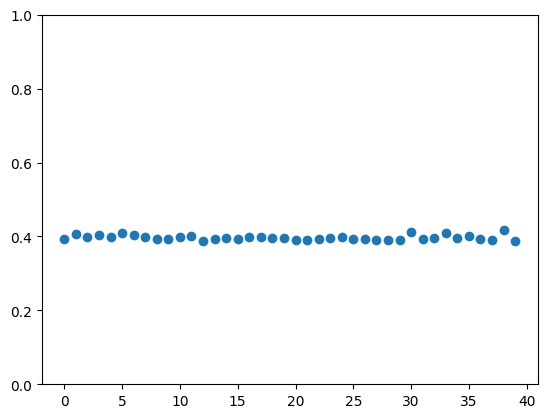

In [60]:
# Baseline
mins = [min(x) for x in model_val_losses]
plot.scatter(range(len(mins)),mins)
plot.ylim(0,1)
std = np.std(np.array(mins))
mean = np.mean(np.array(mins))
print(f"mean, std: {mean}, {std}")
print(f"% error: {100 * std / mean}%")

40
mean, std: 0.39705769373820377, 0.003975239033015128
% error: 1.0011741607596614%


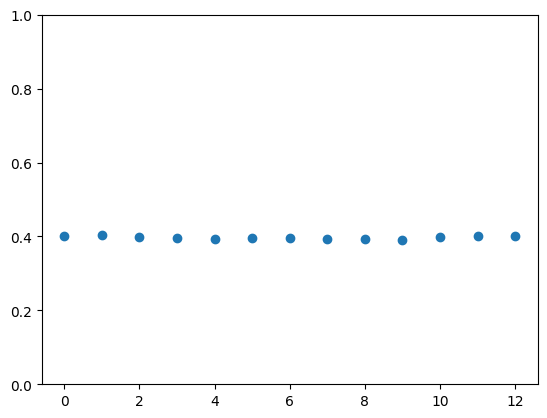

In [58]:
# Average over models
avg_across_models = []
mins = [min(x) for x in model_val_losses]
print(len(mins))
i = 0
while i < 39:
    avg_across_models.append(np.mean(np.array([mins[i],mins[i + 1],mins[i + 2]])))
    i += 3
    
plot.scatter(range(len(avg_across_models)),avg_across_models)
plot.ylim(0,1)
std = np.std(np.array(avg_across_models))
mean = np.mean(np.array(avg_across_models))
print(f"mean, std: {mean}, {std}")
print(f"% error: {100 * std / mean}%")

#### Now trying these methods on binned RMSE

mean, std: 0.39731043577194214, 0.005978165545393198
% error: 1.5046585760522762%


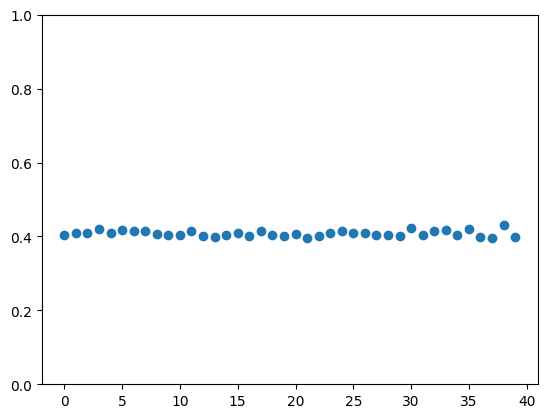

In [59]:
# Average over last 5 epochs
avgs = []
for i in range(len(model_val_losses)):
    avgs.append(np.mean(np.array(model_val_losses[i])[-5:]))
plot.scatter(range(len(avgs)),avgs)
plot.ylim(0,1)
std = np.std(np.array(model_val_losses[i])[-5:])
mean = np.mean(np.array(model_val_losses[i])[-5:])
print(f"mean, std: {mean}, {std}")
print(f"% error: {100 * std / mean}%")

LOW mean, std: 0.49135423849999993, 0.013995744648175846
LOW % error: 2.8484021407654647%
HIGH mean, std: 0.7003404022499999, 0.008390752005015252
HIGH % error: 1.1980962369239425%


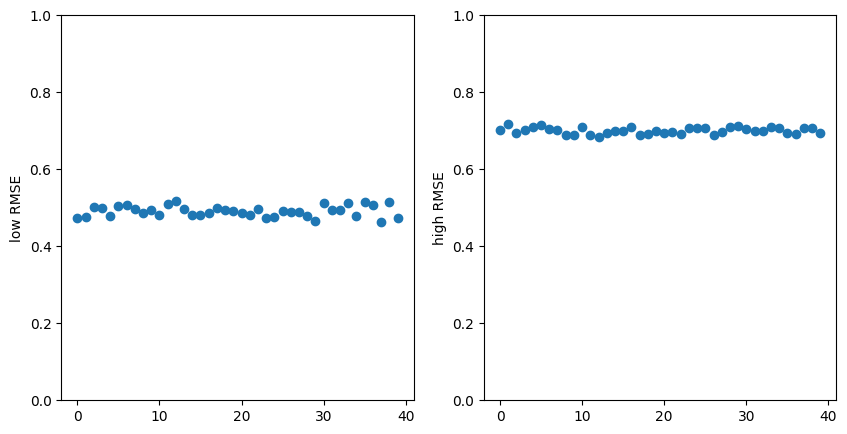

In [61]:
# BASELINE, binned_rmse
low_RMSE = binned_rmses[:,0]
high_RMSE = binned_rmses[:,1]
fig_base,axs_base = plot.subplots(1,2,figsize = (10,5))
axs_base[0].scatter(range(len(low_RMSE)),low_RMSE)
axs_base[0].set_ylim(0,1)
axs_base[0].set_ylabel("low RMSE")
axs_base[1].scatter(range(len(high_RMSE)),high_RMSE)
axs_base[1].set_ylim(0,1)
axs_base[1].set_ylabel("high RMSE")
low_std = np.std(np.array(low_RMSE))
low_mean = np.mean(np.array(low_RMSE))
high_std = np.std(np.array(high_RMSE))
high_mean = np.mean(np.array(high_RMSE))
print(f"LOW mean, std: {low_mean}, {low_std}")
print(f"LOW % error: {100 * low_std / low_mean}%")
print(f"HIGH mean, std: {high_mean}, {high_std}")
print(f"HIGH % error: {100 * high_std / high_mean}%")

LOW mean, std: 0.49183070051282063, 0.00696507856404893
LOW % error: 1.416153679871265%
HIGH mean, std: 0.7005061066666668, 0.004400442439007769
HIGH % error: 0.6281804536932756%


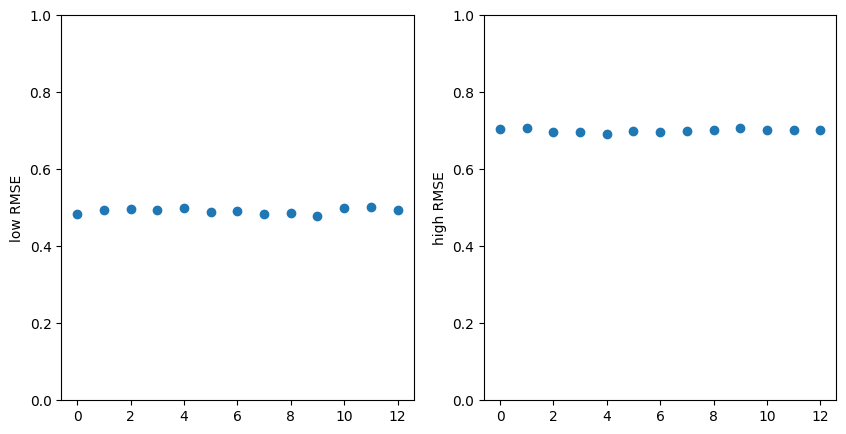

In [62]:
# AVG over models
low_avgs = []
high_avgs = []

i = 0
num_models_avg = 3
while i < 39:
    low_avgs.append(np.mean(binned_rmses[i:i+num_models_avg,0]))
    high_avgs.append(np.mean(binned_rmses[i:i+num_models_avg,1]))
    i += num_models_avg
fig_avgs,axs_avgs = plot.subplots(1,2,figsize = (10,5))
axs_avgs[0].scatter(range(len(low_avgs)),low_avgs)
axs_avgs[0].set_ylim(0,1)
axs_avgs[0].set_ylabel("low RMSE")
axs_avgs[1].scatter(range(len(high_avgs)),high_avgs)
axs_avgs[1].set_ylim(0,1)
axs_avgs[1].set_ylabel("high RMSE")
low_std_avgs = np.std(np.array(low_avgs))
low_mean_avgs = np.mean(np.array(low_avgs))
high_std_avgs = np.std(np.array(high_avgs))
high_mean_avgs = np.mean(np.array(high_avgs))
print(f"LOW mean, std: {low_mean_avgs}, {low_std_avgs}")
print(f"LOW % error: {100 * low_std_avgs / low_mean_avgs}%")
print(f"HIGH mean, std: {high_mean_avgs}, {high_std_avgs}")
print(f"HIGH % error: {100 * high_std_avgs / high_mean_avgs}%")

Low mean, std: 0.6181090602325181, 0.012740380623975428
Low % error: 2.061186519282341%
High mean, std: 0.6173426903858347, 0.01109886586942887
High % error: 1.7978451907306396%


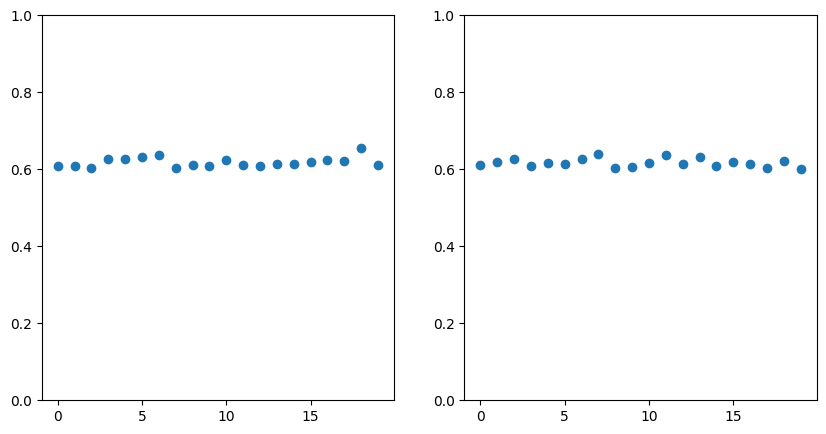

In [66]:
# Average over last 5 epochs
epoch_avgs_low = []
epoch_avgs_high = []
for i in range(len(val_binned_rmses_epochs_list)):
    epoch_avgs_low.append(np.mean(np.array(val_binned_rmses_epochs_list[i])[-5:][0]))
    epoch_avgs_high.append(np.mean(np.array(val_binned_rmses_epochs_list[i])[-5:][1]))
fig_epoch_avg, axs_epoch_avg = plot.subplots(1,2, figsize = (10,5))
axs_epoch_avg[0].scatter(range(len(epoch_avgs_low)),epoch_avgs_low)
axs_epoch_avg[1].scatter(range(len(epoch_avgs_high)),epoch_avgs_high)
axs_epoch_avg[0].set_ylim(0,1)
axs_epoch_avg[1].set_ylim(0,1)
epoch_low_std = np.std(np.array(epoch_avgs_low))
epoch_high_std = np.std(np.array(epoch_avgs_high))
epoch_low_mean = np.mean(np.array(epoch_avgs_low))
epoch_high_mean = np.mean(np.array(epoch_avgs_high))
print(f"Low mean, std: {epoch_low_mean}, {epoch_low_std}")
print(f"Low % error: {100 * epoch_low_std / epoch_low_mean}%")
print(f"High mean, std: {epoch_high_mean}, {epoch_high_std}")
print(f"High % error: {100 * epoch_high_std / epoch_high_mean}%")

In [36]:
def rotate(x,y):
    r = np.sqrt(x * x + y * y)
    angle = np.arctan2(y,x)
    new_angle = angle + (np.pi * 135 / 180)
    new_x = r * np.cos(new_angle)
    new_y = r * np.sin(new_angle)
    return new_x, new_y

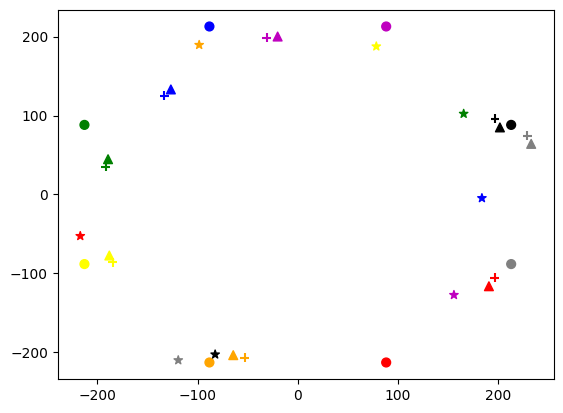

In [37]:
x = [88.12,-88.12,-212.74,-212.74,-88.12,88.12,212.74,212.74]
y = [-212.74,-212.74,-88.12,88.12,212.74,212.74,88.12,-88.12]
x_hit = np.array([1965.04,-527.63,-1844.63,-1915.36,-1330.15,-309.37,1965.90,2289.26]) / 10
y_hit = np.array([-1053.25,-2069.23,-859.37, 349.31,1252.96,1983.03,961.86,744.39]) / 10
x_strip = np.array([-216.90,-98.34,78.27,165.37,183.57,155.67,-82.42,-119.2])
y_strip = np.array([-52.58,189.39,187.52,102.19,-4.583,-127.23,-202.56,-209.87])

new_x_strip,new_y_strip = rotate(x_strip,y_strip)

colors = ["r", "orange", "yellow","green","blue","m","black","grey"]
plot.scatter(x,y,np.ones(8) * 40, color = colors);
plot.scatter(x_hit,y_hit,np.ones(8) * 40,color = colors,marker = "+");
plot.scatter(x_strip,y_strip,np.ones(8) * 40,color = colors,marker = "*");
plot.scatter(new_x_strip,new_y_strip,np.ones(8) * 40,color = colors,marker = "^");

In [48]:
optph_PDG = up.open("../../root_files/test/scint_sense_opticalph_march3_one_layer_50events_mum.edm4hep.root:events")["MCParticles/MCParticles.PDG"].array(library = "np")
x_vertex = up.open("../../root_files/test/scint_sense_opticalph_march3_one_layer_50events_mum.edm4hep.root:events")["MCParticles/MCParticles.vertex.x"].array(library = "np")
scint = up.open("../../root_files/test/scint_sense_opticalph_march3_one_layer_50events_mum.edm4hep.root:events")["HcalBarrelHits/HcalBarrelHits.EDep"].array(library = "np")
x = up.open("../../root_files/test/scint_sense_opticalph_march3_one_layer_50events_mum.edm4hep.root:events")["HcalBarrelHits/HcalBarrelHits.position.x"].array(library = "np")

In [49]:
optph_arr = np.zeros(50)
scint_arr = np.zeros(50)
x_pos = []
x_vertex_pos = []
for i in range(50):
    #get number of optical photons generated
    for j in range(len(optph_PDG[i])):
        if(optph_PDG[i][j] == -22):
            optph_arr[i] += 1
            x_vertex_pos.append(x_vertex[i][j])
    #get total energy deposited
    for j in range(len(scint[i])):
        scint_arr[i] += scint[i][j]
        x_pos.append(x[i][j])

In [35]:
print(f"#photons: {optph_arr}\nEDep: {scint_arr}")

#photons: [ 535096. 2535373.  454576.  642646.  560824.  457685.  546959.  765565.
  496636.  634389.  561248.  568769.  624459.  705217.  581478.  702495.
  504315.  634976.  615618.  658391.  545628.  479912.  600605.  580499.
  685371.  563172.  600581.  598233.  600215.  605920.  588763.  850654.
  608943.  652537.  668617.  607403.  561049.  648131.  637722.  640798.
  570193.  601125.  505866.  841677.  464352.  639725.  581133.  531960.
  519940.  536555.]
EDep: [0.05282294 0.25599313 0.04481486 0.06334567 0.05527346 0.04494669
 0.05380926 0.07534926 0.04888599 0.06245465 0.05526025 0.05621166
 0.0617437  0.06953112 0.05736857 0.06931826 0.04970132 0.06273607
 0.06062843 0.06483334 0.05367621 0.04713684 0.059166   0.05725005
 0.06739591 0.0555676  0.05918125 0.05900898 0.05915384 0.05973282
 0.05793397 0.08373215 0.06000016 0.06441965 0.06609493 0.06006661
 0.05532032 0.06395576 0.06291519 0.06324783 0.05625302 0.05945038
 0.0497877  0.08295196 0.04568942 0.0632119  0.05736921 0

In [41]:
def calculate_num_photons(energy_dep):
    return 10 * energy_dep * (1000 * 1000)
print(f"#photons: {optph_arr // 10000}\nEDep: {calculate_num_photons(scint_arr) // 10000}")

#photons: [ 53. 253.  45.  64.  56.  45.  54.  76.  49.  63.  56.  56.  62.  70.
  58.  70.  50.  63.  61.  65.  54.  47.  60.  58.  68.  56.  60.  59.
  60.  60.  58.  85.  60.  65.  66.  60.  56.  64.  63.  64.  57.  60.
  50.  84.  46.  63.  58.  53.  51.  53.]
EDep: [ 52. 255.  44.  63.  55.  44.  53.  75.  48.  62.  55.  56.  61.  69.
  57.  69.  49.  62.  60.  64.  53.  47.  59.  57.  67.  55.  59.  59.
  59.  59.  57.  83.  60.  64.  66.  60.  55.  63.  62.  63.  56.  59.
  49.  82.  45.  63.  57.  52.  51.  52.]


In [43]:
print(f"difference: {(optph_arr - calculate_num_photons(scint_arr)) // 1000}")

difference: [  6. -25.   6.   9.   8.   8.   8.  12.   7.   9.   8.   6.   7.   9.
   7.   9.   7.   7.   9.  10.   8.   8.   8.   7.  11.   7.   8.   8.
   8.   8.   9.  13.   8.   8.   7.   6.   7.   8.   8.   8.   7.   6.
   7.  12.   7.   7.   7.   8.   6.   8.]


(1700.0, 2900.0)

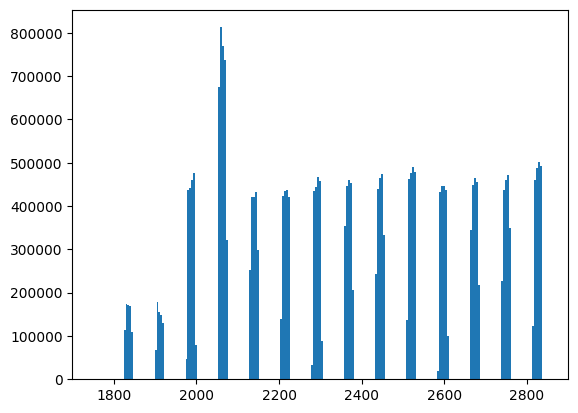

In [47]:
plot.hist(x_pos,bins = 1000);
plot.xlim(1700,2900)

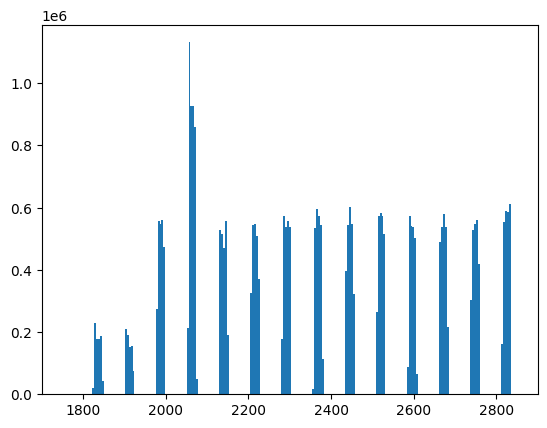

In [50]:
plot.hist(x_vertex_pos,bins = 1000);
plot.xlim(1700,2900);

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
from time_res_util import get_compiled_NF_model
import torch
from momentum_prediction_util import load_defaultdict, get_key
from tqdm import tqdm
import time
from itertools import groupby
from GNN_util import process_df_vectorized,create_directory,HitDataset,create_fast_edge_lists,visualize_detector_graph,GIN,train_GNN,test_GNN,calculate_bin_rmse
from dgl.data import DGLDataset
import dgl

In [104]:
class SiPMSignalProcessorNEW:
    def __init__(self, 
                 sampling_rate=40e9,  # 40 GHz sampling rate
                 tau_rise=1.1e-9,       # 1 ns rise time
                 tau_fall=15e-9,      # 50 ns fall time
                 window=200e-9,       # 200 ns time window
#                  cfd_delay=5e-9,      # 5 ns delay for CFD
                 cfd_fraction=0.3):   # 30% fraction for CFD
        
        self.sampling_rate = sampling_rate
        self.tau_rise = tau_rise
        self.tau_fall = tau_fall
        self.window = window
#         self.cfd_delay = cfd_delay
        self.cfd_fraction = cfd_fraction
        self.cfd_delay = self.tau_rise * (1 - self.cfd_fraction)
        
        # Time array for single pulse shape
        self.time = np.arange(0, self.window, 1/self.sampling_rate)
        
        # Generate single pulse shape
        self.pulse_shape = self._generate_pulse_shape()
    
    def _generate_pulse_shape(self):
        """Generate normalized pulse shape for a single photon"""
        shape = np.exp(-self.time/self.tau_fall) - np.exp(-self.time/self.tau_rise)
        return shape / np.max(shape)  # Normalize
    
    def generate_waveform(self, photon_times):
        """Generate waveform from list of photon arrival times"""
        # Initialize waveform array
        waveform = np.zeros_like(self.time)
        
        # Add pulse for each photon
        for t in photon_times:
            if 0 <= t < self.window:
                idx = int(t * self.sampling_rate)
                remaining_samples = len(self.time) - idx
                waveform[idx:] += self.pulse_shape[:remaining_samples]
        
        return self.time, waveform
    
    def integrate_charge(self, waveform, integration_start=0, integration_time=100e-9):
        """Integrate charge in specified time window"""
        start_idx = int(integration_start * self.sampling_rate)
        end_idx = int((integration_start + integration_time) * self.sampling_rate)
        
        # Integrate using trapezoidal rule
        charge = np.trapezoid(waveform[start_idx:end_idx], dx=1/self.sampling_rate)
        return charge
    def constant_threshold_timing(self,waveform,threshold):
        for i in range(len(self.time)):
            if(waveform[i] > threshold):
                return self.time[i]
        return None
        
    def apply_cfd(self, waveform, use_interpolation=True):
        """Apply Constant Fraction Discrimination to the waveform.

        Parameters:
        -----------
        waveform : numpy.ndarray
            Input waveform to process
        use_interpolation : bool, optional
            If True, use linear interpolation for sub-sample precision
            If False, return the sample index of zero crossing
            Default is True

        Returns:
        --------
        tuple (numpy.ndarray, float)
            CFD processed waveform and the zero-crossing time in seconds.
            If use_interpolation is False, zero-crossing time will be aligned
            to sample boundaries.
        """
        # Calculate delay in samples
        delay_samples = int(self.cfd_delay * self.sampling_rate)

        # Create delayed and attenuated versions of the waveform
        delayed_waveform = np.pad(waveform, (delay_samples, 0))[:-delay_samples]
        attenuated_waveform = -self.cfd_fraction * waveform

        # Calculate CFD waveform
        cfd_waveform = delayed_waveform + attenuated_waveform

        # Find all zero crossings
        zero_crossings = np.where(np.diff(np.signbit(cfd_waveform)))[0]

        if len(zero_crossings) < 2:  # Need at least two crossings for valid CFD
            return cfd_waveform, None

        # Find the rising edge of the original pulse
        pulse_start = np.where(waveform > np.max(waveform) * self.cfd_fraction)[0]  # cfd fraction threshold
        if len(pulse_start) == 0:
            return cfd_waveform, None
        pulse_start = pulse_start[0]

        # Find the first zero crossing that occurs after the pulse starts
        valid_crossings = zero_crossings[zero_crossings > pulse_start]
        if len(valid_crossings) == 0:
            return cfd_waveform, None

        crossing_idx = valid_crossings[0]

        if not use_interpolation:
            # Simply return the sample index converted to time
            crossing_time = crossing_idx / self.sampling_rate
        else:
            # Use linear interpolation for sub-sample precision
            y1 = cfd_waveform[crossing_idx]
            y2 = cfd_waveform[crossing_idx + 1]

            # Calculate fractional position of zero crossing
            fraction = -y1 / (y2 - y1)

            # Calculate precise crossing time
            crossing_time = (crossing_idx + fraction) / self.sampling_rate

        return cfd_waveform, crossing_time


    def get_pulse_timing(self, waveform, threshold=0.1):
        """Get pulse timing using CFD method with additional validation.
        
        Parameters:
        -----------
        waveform : numpy.ndarray
            Input waveform to analyze
        threshold : float
            Minimum amplitude threshold for valid pulses (relative to max amplitude)
            
        Returns:
        --------
        float or None
            Timestamp of the pulse in seconds, or None if no valid pulse found
        """
        # Check if pulse amplitude exceeds threshold
        max_amplitude = np.max(waveform)
        if max_amplitude < threshold:
            return None
            
        # Apply CFD
        _, crossing_time = self.apply_cfd(waveform)
        
        return crossing_time, _

In [116]:
class SiPMSignalProcessor:
    def __init__(self, 
                 sampling_rate=40e9,  # 40 GHz sampling rate
                 tau_rise=1.1e-9,       # 1 ns rise time
                 tau_fall=15e-9,      # 50 ns fall time
                 window=200e-9,       # 200 ns time window
                 cfd_delay=5e-9,      # 5 ns delay for CFD
                 cfd_fraction=0.3):   # 30% fraction for CFD
        
        self.sampling_rate = sampling_rate
        self.tau_rise = tau_rise
        self.tau_fall = tau_fall
        self.window = window
        self.cfd_delay = cfd_delay
        self.cfd_fraction = cfd_fraction
#         self.cfd_delay = self.tau_rise * (1 - self.cfd_fraction)
        
        # Time array for single pulse shape
        self.time = np.arange(0, self.window, 1/self.sampling_rate)
        
        # Generate single pulse shape
        self.pulse_shape = self._generate_pulse_shape()
    
    def _generate_pulse_shape(self):
        """Generate normalized pulse shape for a single photon"""
        shape = np.exp(-self.time/self.tau_fall) - np.exp(-self.time/self.tau_rise)
        return shape / np.max(shape)  # Normalize
    
    def generate_waveform(self, photon_times):
        """Generate waveform from list of photon arrival times"""
        # Initialize waveform array
        waveform = np.zeros_like(self.time)
        
        # Add pulse for each photon
        for t in photon_times:
            if 0 <= t < self.window:
                idx = int(t * self.sampling_rate)
                remaining_samples = len(self.time) - idx
                waveform[idx:] += self.pulse_shape[:remaining_samples]
        
        return self.time, waveform
    
    def integrate_charge(self, waveform, integration_start=0, integration_time=100e-9):
        """Integrate charge in specified time window"""
        start_idx = int(integration_start * self.sampling_rate)
        end_idx = int((integration_start + integration_time) * self.sampling_rate)
        
        # Integrate using trapezoidal rule
        charge = np.trapezoid(waveform[start_idx:end_idx], dx=1/self.sampling_rate)
        return charge
    def constant_threshold_timing(self,waveform,threshold):
        for i in range(len(self.time)):
            if(waveform[i] > threshold):
                return self.time[i]
        return None
        
    def apply_cfd(self, waveform, use_interpolation=True):
        """Apply Constant Fraction Discrimination to the waveform.

        Parameters:
        -----------
        waveform : numpy.ndarray
            Input waveform to process
        use_interpolation : bool, optional
            If True, use linear interpolation for sub-sample precision
            If False, return the sample index of zero crossing
            Default is True

        Returns:
        --------
        tuple (numpy.ndarray, float)
            CFD processed waveform and the zero-crossing time in seconds.
            If use_interpolation is False, zero-crossing time will be aligned
            to sample boundaries.
        """
        # Calculate delay in samples
        delay_samples = int(self.cfd_delay * self.sampling_rate)

        # Create delayed and attenuated versions of the waveform
        delayed_waveform = np.pad(waveform, (delay_samples, 0))[:-delay_samples]
        attenuated_waveform = -self.cfd_fraction * waveform

        # Calculate CFD waveform
        cfd_waveform = delayed_waveform + attenuated_waveform

        # Find all zero crossings
        zero_crossings = np.where(np.diff(np.signbit(cfd_waveform)))[0]

        if len(zero_crossings) < 2:  # Need at least two crossings for valid CFD
            return cfd_waveform, None

        # Find the rising edge of the original pulse
        pulse_start = np.where(waveform > np.max(waveform) * 0.1)[0]  # cfd fraction threshold
        if len(pulse_start) == 0:
            return cfd_waveform, None
        pulse_start = pulse_start[0]

        # Find the first zero crossing that occurs after the pulse starts
        valid_crossings = zero_crossings[zero_crossings > pulse_start]
        if len(valid_crossings) == 0:
            return cfd_waveform, None

        crossing_idx = valid_crossings[0]

        if not use_interpolation:
            # Simply return the sample index converted to time
            crossing_time = crossing_idx / self.sampling_rate
        else:
            # Use linear interpolation for sub-sample precision
            y1 = cfd_waveform[crossing_idx]
            y2 = cfd_waveform[crossing_idx + 1]

            # Calculate fractional position of zero crossing
            fraction = -y1 / (y2 - y1)

            # Calculate precise crossing time
            crossing_time = (crossing_idx + fraction) / self.sampling_rate

        return cfd_waveform, crossing_time


    def get_pulse_timing(self, waveform, threshold=0.1):
        """Get pulse timing using CFD method with additional validation.
        
        Parameters:
        -----------
        waveform : numpy.ndarray
            Input waveform to analyze
        threshold : float
            Minimum amplitude threshold for valid pulses (relative to max amplitude)
            
        Returns:
        --------
        float or None
            Timestamp of the pulse in seconds, or None if no valid pulse found
        """
        # Check if pulse amplitude exceeds threshold
        max_amplitude = np.max(waveform)
        if max_amplitude < threshold:
            print("Failed to pass threshold")
            return None
            
        # Apply CFD
        cfd_waveform, crossing_time = self.apply_cfd(waveform)
        
        return crossing_time, cfd_waveform

In [121]:
new_p = SiPMSignalProcessor()
a, b = new_p.get_pulse_timing(waveform)

In [118]:

processer = SiPMSignalProcessor()

In [106]:
normalizing_flow = model_compile
batch_size=50000
device='cuda'
pixel_threshold = 5
useCFD = True
all_context = []
all_time_pixels = []
all_metadata = []
num_pixel_list = ["num_pixels_high_z","num_pixels_low_z"]
print("Processing data in new_prepare_nn_input...")
for event_idx, event_data in tqdm(processed_data.items()):
    for stave_idx, stave_data in event_data.items():
        for layer_idx, layer_data in stave_data.items():
            for segment_idx, segment_data in layer_data.items():
                trueID_list = []
                for particle_id, particle_data in segment_data.items():
                    # Need z, theta, p for sampling from NF
                    base_context = torch.tensor([particle_data['z_pos'], particle_data['hittheta'], particle_data['hitmomentum']], 
                                                dtype=torch.float32)
                    # Need time of track hit to get absolute time of photon hit
                    base_time_pixels_low = torch.tensor([particle_data['time'], particle_data['num_pixels_low_z']], 
                                                    dtype=torch.float32)
                    base_time_pixels_high = torch.tensor([particle_data['time'], particle_data['num_pixels_high_z']], 
                                                    dtype=torch.float32)
                    if particle_data['trueID'] not in  trueID_list:
                        trueID_list.append(particle_data['trueID'])
                    for SiPM_idx in range(2):
                        z_pos = particle_data['z_pos']
                        context = base_context.clone()
                        context[0] = z_pos
                        num_pixel_tag = num_pixel_list[SiPM_idx]
                        all_context.append(context.repeat(particle_data[num_pixel_tag], 1))
                        if(SiPM_idx == 0):
                            all_time_pixels.append(base_time_pixels_high.repeat(particle_data[num_pixel_tag], 1))
                        else:
                            all_time_pixels.append(base_time_pixels_low.repeat(particle_data[num_pixel_tag], 1))
                        # Assuming particle_data is a dictionary-like object and trueID_list is defined
                        fields = [
                            'truemomentum', 'trueID', 'truePID', 'hitID', 'hitPID', 
                            'truetheta', 'truephi', 'strip_x', 'strip_y', 'strip_z', 
                            'hit_x', 'hit_y', 'hit_z', 'KMU_trueID', 'KMU_truePID', 
                            'KMU_true_phi', 'KMU_true_momentum_mag', 'KMU_endpoint_x', 
                            'KMU_endpoint_y', 'KMU_endpoint_z'
                        ]

                        all_metadata.extend([(event_idx,stave_idx, layer_idx,segment_idx, SiPM_idx, particle_data['truemomentum'],particle_data['trueID'],particle_data['truePID'],particle_data['hitID'],particle_data['hitPID'],particle_data['truetheta'],particle_data['truephi'],particle_data['strip_x'],particle_data['strip_y'],particle_data['strip_z'],len(trueID_list),particle_data['hit_x'],particle_data['hit_y'],particle_data['hit_z'],particle_data['KMU_trueID'],particle_data['KMU_truePID'],particle_data['KMU_true_phi'],particle_data['KMU_true_momentum_mag'],particle_data['KMU_endpoint_x'],particle_data['KMU_endpoint_y'],particle_data['KMU_endpoint_z'])] * particle_data[num_pixel_tag])

all_context = torch.cat(all_context)
all_time_pixels = torch.cat(all_time_pixels)

print("Sampling data...")
sampled_data = []
begin = time.time()
for i in tqdm(range(0, len(all_context), batch_size)):
    batch_end = min(i + batch_size, len(all_context))
    batch_context = all_context[i:batch_end].to(device)
    batch_time_pixels = all_time_pixels[i:batch_end]

    with torch.no_grad():
        samples = abs(normalizing_flow.sample(num_samples=len(batch_context), context=batch_context)[0]).squeeze(1)

    sampled_data.extend(samples.cpu() + batch_time_pixels[:, 0])
end = time.time()
print(f"sampling took {end - begin} seconds")

Processing data in new_prepare_nn_input...


100%|██████████| 49/49 [00:03<00:00, 14.62it/s]


Sampling data...


100%|██████████| 109/109 [01:14<00:00,  1.47it/s]

sampling took 74.10446572303772 seconds


In [138]:
print("Processing signal...")
processor = SiPMSignalProcessor()
rows = []
trueID_dict = {}
trueID_dict_running_idx = 0
event_first_hits = {}
finish = False
# Sort the data first (required for groupby)
sorted_data = sorted(zip(all_metadata, sampled_data), key=get_key)

# Process each group
for key, group in groupby(sorted_data, key=get_key):
    if(finish):
        break
    event_idx, stave_idx, layer_idx, segment_idx = key

    # Initialize arrays for both SiPMs
    sipm_samples = [[], []]

    # Get the first metadata tuple for this group (they should all be the same within a group)
    first_item = next(group)
    metadata = first_item[0]
    _, _, _, _, _, momentum,trueID,truePID,hitID,hitPID,theta,phi,strip_x,strip_y,strip_z,trueID_list_len,hit_x,hit_y,hit_z,KMU_trueID,KMU_truePID,KMU_true_phi,KMU_true_momentum_mag,KMU_endpoint_x,KMU_endpoint_y,KMU_endpoint_z = metadata
    sipm_samples[first_item[0][4]].append(first_item[1])

    # Process rest of group
    for metadata, sample in group:
        sipm_idx = metadata[4]
        sipm_samples[sipm_idx].append(sample)

    # Process each SiPM's samples
    SiPM_info = {}
    translated_trueID = -1
    for curr_SiPM_idx in range(2):
        if not sipm_samples[curr_SiPM_idx]:
            SiPM_info[f"Time{curr_SiPM_idx}"] = 0
            SiPM_info[f"Charge{curr_SiPM_idx}"] = 0
            continue

        photon_times = np.array(sipm_samples[curr_SiPM_idx]) * 10**(-9)
        time_arr, waveform = processor.generate_waveform(photon_times)
        print(f"Number of photons: {len(photon_times)}")
        if(len(photon_times) > 10):
            finish = True
            break
        

Processing signal...
Number of photons: 1296


In [127]:
processorNEW = SiPMSignalProcessorNEW()

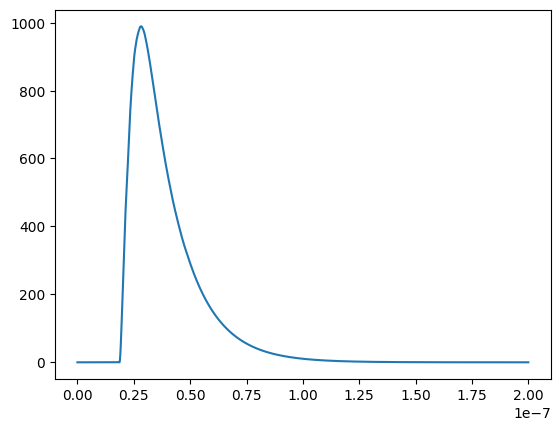

In [139]:
plot.plot(time_arr,waveform)

In [141]:

timing_oldCFD = processor.get_pulse_timing(waveform, threshold=pixel_threshold)
timing_newCFD = processorNEW.get_pulse_timing(waveform, threshold=pixel_threshold)
timing_constant = processor.constant_threshold_timing(waveform,threshold = pixel_threshold)

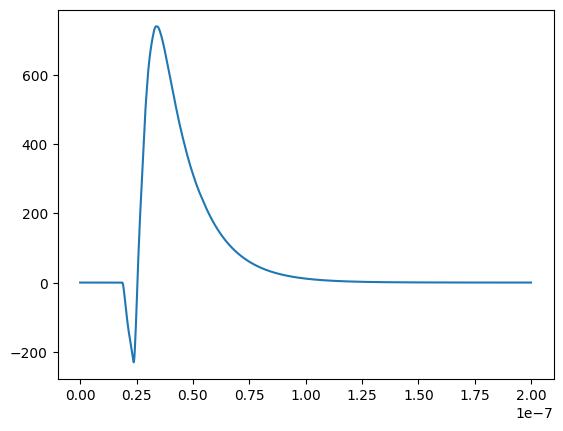

In [144]:
plot.plot(time_arr, timing_oldCFD[1])

In [73]:
model_compile = get_compiled_NF_model(thickness = "2cm")
inputProcessedData = "/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/processed_data/Feb_9_50events_run_0_3.json"
# inputProcessedData = "/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/processed_data/old_CFD_Feb_10_50events_run_3_4.json"
processed_data = load_defaultdict(inputProcessedData)

/hpc/group/vossenlab/rck32/ML_venv/lib64/python3.9/site-packages/normflows/core.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


In [74]:
prepared_df = newer_prepare_nn_input(processed_data,model_compile,batch_size = 50000)

Processing data in new_prepare_nn_input...


100%|██████████| 49/49 [00:03<00:00, 16.11it/s]


Sampling data...


100%|██████████| 109/109 [01:13<00:00,  1.48it/s]


sampling took 73.72666501998901 seconds
Processing signal...


In [75]:
class HitDataset(DGLDataset):
    def __init__(self, data, filter_events,connection_mode = "kNN",max_distance = 0.5,k = 6):
        self.data = data
        self.filter_events = filter_events
        self.max_distance = max_distance
        self.event_data = torch.tensor([])
        self.connection_mode = connection_mode
        self.k = k
        self.dfs = []
        self.mass_dict = {130 : 0.497611}
        super().__init__(name = "KLM_reco")
    def get_max_distance_edges(self,curr_event):
        x = curr_event['strip_x'].values
        y = curr_event['strip_y'].values

        # Create coordinate matrices
        x_diff = x[:, np.newaxis] - x[np.newaxis, :]  # Creates a matrix of all x differences
        y_diff = y[:, np.newaxis] - y[np.newaxis, :]  # Creates a matrix of all y differences

        # Compute distances in one go
        distances = np.sqrt(x_diff**2 + y_diff**2)

        # Create mask for valid edges (upper triangle only to avoid duplicates)
        upper_mask = (distances < self.max_distance) & (np.triu(np.ones_like(distances), k=1) > 0)

        # Get edge indices for upper triangle
        src_upper, dst_upper = np.where(upper_mask)

        # Create the bidirectional edges
        sources = np.concatenate([src_upper, dst_upper])
        destinations = np.concatenate([dst_upper, src_upper])
        return sources,destinations
    def get_knn_edges(self,curr_event):
        """ 
        Given x and y coordinates of nodes, compute edges for a k-NN graph.

        Args:
            x (numpy array): x-coordinates of nodes.
            y (numpy array): y-coordinates of nodes.
            k (int): Number of nearest neighbors.

        Returns:
            sources (numpy array): List of source nodes.
            destinations (numpy array): List of destination nodes.
        """
        x = curr_event['strip_x'].values
        y = curr_event['strip_y'].values
        n = len(x)

        # The first notation with "np.newaxis" is the same as tensor.unsqueeze(-1)
        # It puts each value in its own dimension, like
        # x = np.arrayy([[a],[b],[c]]), so size is (N,1) rather than (N)
        # The second notation (x[np.newaxis,:]) just puts the array in another array so that the size is (1,N
        # rather than (N)
        x_diff = x[:, np.newaxis] - x[np.newaxis, :]
        y_diff = y[:, np.newaxis] - y[np.newaxis, :]
        
        # distances has shape (N,N) - matrix where the diagonal is 0, each entry is the distance between
        # the ith (column idx) node and the jth (row idx) node
        distances = np.sqrt(x_diff**2 + y_diff**2)

        # Get the indices of the k nearest neighbors for each node (excluding self-connections)
        # argsort sorts each row by the distance and returns the sorted indices
        # We use the [:,1:k+1] to take the first k indices besides the lowest (which is the diagonal self connection)
        knn_indices = np.argsort(distances, axis=1)[:, 1:self.k+1]

        # Create source and destination lists
        sources = np.concatenate([np.repeat(np.arange(n), self.k),knn_indices.flatten()])
        destinations = np.concatenate([knn_indices.flatten(),np.repeat(np.arange(n), self.k)])

        return sources, destinations
        
    def process(self):
        events_group = self.data.groupby(["event_idx","file_idx"])
        self.labels = torch.tensor([])
        self.graphs = []
        it_idx = 0
        for event_idx in events_group.groups:
            curr_event = events_group.get_group(event_idx)
            nhits = len(curr_event)
            '''FIRST FILTER FOR EVENTS'''
            if(self.filter_events):
                ModifiedTrueID_unique = np.array(curr_event['ModifiedTrueID'].unique())
                valid_ModifiedTrueID_unique = ModifiedTrueID_unique[ModifiedTrueID_unique != -1]
                #skip events with multiple valid trueIDs
                if(len(valid_ModifiedTrueID_unique) > 1):
                    continue
            
                #skip events with no valid ModififiedTrueIDs
                if(len(valid_ModifiedTrueID_unique) == 0):
                    continue
                # Remove rows that are hits outside of the cone
                curr_event = curr_event[curr_event.ModifiedTrueID != -1]
                nhits = len(curr_event)
            # Skip graphs with only 1 hit (or 0)
            if(nhits <2):
                continue;
            elif(nhits <self.k):
                sources = np.concatenate([np.repeat(np.arange(nhits),nhits),np.tile(np.arange(nhits),nhits)])
                destinations = np.concatenate([np.tile(np.arange(nhits),nhits),np.repeat(np.arange(nhits),nhits)])
            else:
                if(self.connection_mode == "max distance"):
                    sources, destinations = self.get_max_distance_edges(curr_event)
                elif(self.connection_mode == "kNN"):
                    sources, destinations = self.get_knn_edges(curr_event)
            g = dgl.graph((sources, destinations), num_nodes=nhits)
            #Want to predict energy
            try:
                mass = self.mass_dict[curr_event["truePID"].to_numpy()[0]]
            except Exception as e:
                truePID = curr_event["truePID"].to_numpy()[0]
                print(f"Exception: {e}")
                print(f"Particle with truePID of {truePID} not in dictionary. Skipping...")
                continue
            momentum = curr_event["P"].to_numpy()[0]
            energy = np.sqrt(mass**2 + momentum**2)
            label = torch.tensor(energy)
            '''VERSION LABEL INCLUDING EVENT FEATURES'''
            # Since this is the version with both SiPM in one hit/node, we have 2 times and charges
            # I hope that doing this will avoid making the NN learn that two hits at the same position are 
            # closely related
            feats = np.stack((
                curr_event["strip_x"].to_numpy() / 300,curr_event["strip_y"].to_numpy() / 300,
                curr_event["Time0"].to_numpy() / 5,
                curr_event["Charge0"].to_numpy(),
                curr_event["Time1"].to_numpy() / 5,
                curr_event["Charge1"].to_numpy()
#                 curr_event["stave_idx"].to_numpy(),
#                 curr_event["layer_idx"].to_numpy(),
#                 curr_event["segment_idx"].to_numpy()
            ),axis = -1)
            g.ndata["feat"] = torch.tensor(feats)#.unsqueeze(-1)
            self.dfs.append(curr_event)
            # Sort hits by time

            # Basic features
            total_charge = curr_event['Charge1'].sum() + curr_event['Charge0'].sum()
            max_charge = max([curr_event['Charge1'].max(),curr_event['Charge0'].max()])
            n_hits = len(curr_event)

            # Spatial features
#             hit_coords = curr_event[['strip_x', 'strip_y']].values

            # Center of gravity
#             cog_x = np.average(hit_coords[:, 0], weights=curr_event['Charge0'] + curr_event['Charge1'])
#             cog_y = np.average(hit_coords[:, 1], weights=curr_event['Charge0'] + curr_event['Charge1'])

            # Feature vector for this event
            event_features = torch.from_numpy(np.stack((label,
                total_charge,
                max_charge,
                n_hits,
#                 cog_x,
#                 cog_y,

                ),axis = -1))
            if(self.labels.shape[0] == 0):
                self.labels = event_features
            else:
                self.labels = torch.vstack((self.labels,event_features))
            #add graph to dataset
            self.graphs.append(g)
            it_idx += 1
        self.dim_nfeats = self.graphs[0].ndata["feat"].shape[1]
        self.dim_event_feats = self.labels.shape[1] - 1
        self.labels = self.labels.clone().detach().float()

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

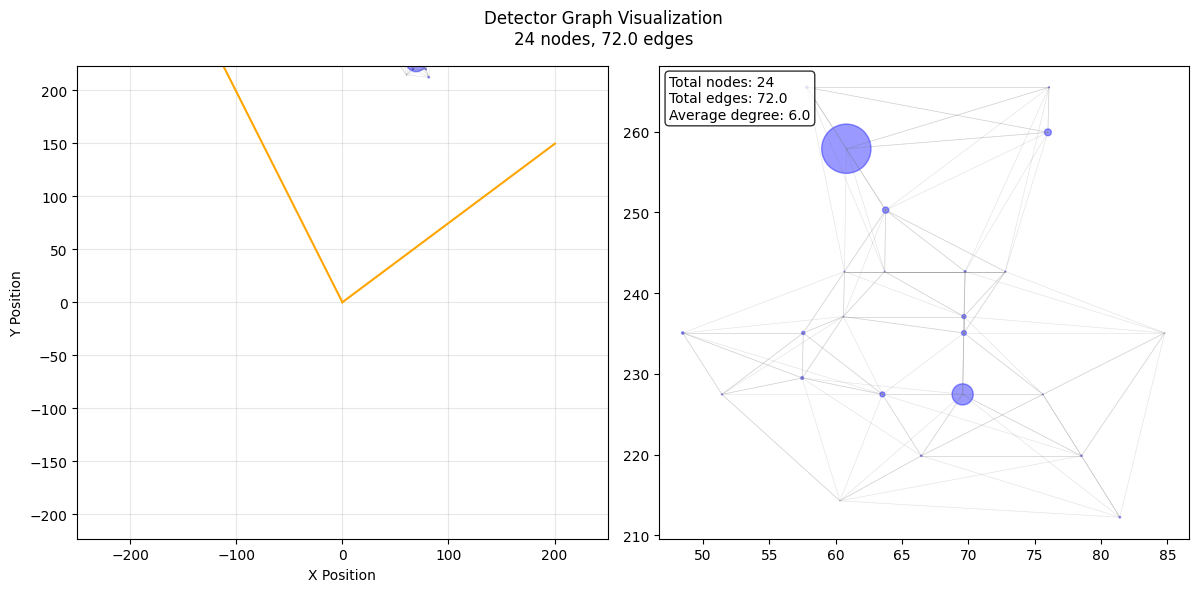

In [76]:

prepared_df["file_idx"] = 0
modified_df = process_df_vectorized(prepared_df, cone_angle_deg = 40)
dataset = HitDataset(modified_df,True,connection_mode = "kNN",k = 6)
visualize_detector_graph(dataset,graph_idx = 0)

In [8]:
from pathlib import Path
my_file = Path("/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/test.txt")
if(my_file.is_file()):
    my_file.unlink()
    print(f"deleted /hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/test.py")

deleted /hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/test.py
